In [1]:
import csv
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats
import colorcet as cc

import statsmodels.api as sm

import bokeh.io
import bokeh.plotting
import bokeh.palettes
import bokeh.models
from bokeh.transform import jitter, factor_cmap

import tqdm
import re

import random
random.seed(42)

import iqplot
import numba
import itertools

bokeh.io.output_notebook()

import warnings
warnings.filterwarnings('ignore')

import pdb

Loading BokehJS ...

In [2]:
def general_hill(x, Ka, n, A, B, C):
    """
    Use a generalized hill function for the calibration curve.
    """
    
    y = B + A / (C + (Ka / x) ** n)
    
    return y

def inverse_general_hill(y, Ka, n, A, B, C):
    """
    Inverse function for deriving concentrations from fluorescence values.
    """
    
    x = Ka / ((A / (y - B) - C) ** (1/n))
    
    return x

def get_calib_data(fluor_df):
    """
    Function to extract calibration data from the general dataframe(s).
    """
    
    calib_df = fluor_df.loc[fluor_df['Strain'] == 'calibration']
    calib_df['Condition Conc. (µM)'] = calib_df['Condition Conc. (µM)'].astype(float)
    
    return calib_df

def plot_calib_point(calib_df, title=None, alpha=0.05):
    """
    Plotter for the calibration data.
    """
    
    
    fig = bokeh.plotting.figure(height=400, 
                                width=600, 
                                title=title, 
                                x_axis_label='µM PCAred', 
                                y_axis_label='Fluorescence (AU)')
    
    c = fig.circle(calib_df['Condition Conc. (µM)'].values, 
                   calib_df['PCAred fluorescence (AU)'].values, 
                   size=5, 
                   alpha=alpha, 
                   legend_label='Calibration measurements')
    
    fig.legend.location = 'bottom_right'
    
    return fig
    
def fit_hill(calib_df, alpha=0.05, show_plot=False, p0=[150, 2, 40000, 5000, 1]):
    """
    Function to fit the generalized Hill function to the calibration data.
    """
    
    xdata = calib_df['Condition Conc. (µM)'].values
    ydata = calib_df['PCAred fluorescence (AU)'].values
    
    popt, pcov = scipy.optimize.curve_fit(general_hill, xdata, ydata, p0=p0)
    
    plot = plot_calib_point(calib_df, title='Fit of calibration model', alpha=alpha)
    
    x = np.linspace(0, 300, 100)
    fit = general_hill(x, *popt)
    
    plot.line(x, fit, color='black')
    
    if show_plot:
        bokeh.io.show(plot)
    
    return popt, pcov

def convert_fluor_to_conc(fluor_exp_df, popt):
    """
    Function to convert fluorescence measurements to concentrations.
    """
    
    fluor_exp_df['measured PCAred (µM)'] = [inverse_general_hill(f, *popt) for f in fluor_exp_df['PCAred fluorescence (AU)']]
    
    return fluor_exp_df

def fitting_pipeline(df, p0=[150, 2, 40000, 5000, 1], show_plot=False):
    """
    Function to bring above utilities together.
    """
    
    calib_df = get_calib_data(df)
    exp_df = df.loc[df['Strain'] != 'calibration']
    
    popt, pcov = fit_hill(calib_df, p0=p0, show_plot=show_plot)
    
    exp_df = convert_fluor_to_conc(exp_df, popt)
    
    return exp_df

def linear_approximation(x_array, y_array, cutoff_time):
    """
    Function to perform a linear regression of the data up to a
    specified cutoff time. Used for generating supplementary figs 5 and 6.
    """
    
    indices = x_array < cutoff_time
    
    x = x_array[indices]
    y = y_array[indices]
    
    slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x, y)
    
    return slope, intercept, rvalue

def linear_range_evaluator(single_strain_single_condition_df, y_var, title=None):
    """
    Assesses the goodness of linear fit over the data for all possible cutoff times.
    Used for supplementary figs 5 and 6.
    """
    
    df = single_strain_single_condition_df.dropna()
    
    x_array = df['Time [hr]'].values
    y_array = df[y_var].values
    
    try:
        start = min(x_array)
    except:
        start = 0
    
    try:
        stop = max(x_array)
    except:
        stop = 24
    
    cutoff_times = np.linspace(start, stop, 48)
    
    r_squareds = []
    slopes = []
    ints = []
    
    for ct in cutoff_times:
        
        try:
            s, i, r = linear_approximation(x_array, y_array, ct)

            r_squareds.append(r**2)
            slopes.append(s)
            ints.append(i)
            
        except:
            r_squareds.append(None)
            slopes.append(None)
            ints.append(None)
            
    
    source = bokeh.models.ColumnDataSource(data=dict(cutoff_times=cutoff_times,
                                                     r_squareds=r_squareds,
                                                     slope_int=[f'slope: {s}\nintercept:{i}' for s, i in zip(slopes, ints)])
                                          )
        
    fig = bokeh.plotting.figure(width=200,
                                height=200,
                                x_axis_label='Cutoff time (hours)',
                                y_axis_label='R-squared',
                                title=title)
    
    c = fig.circle(x='cutoff_times', y='r_squareds', source=source)
    
    l = fig.line([start + 5, start + 5], [0, 1], color='red')
    
#     labels = bokeh.models.LabelSet(x='cutoff_times', y='r_squared', text='slope_int',
#                                    x_offset=5, y_offset=5, source=source)
    
#     fig.add_layout(labels)
    
    fig.y_range = bokeh.models.Range1d(0, 1.05)
    fig.output_backend = 'svg'
    
    return fig

def linear_assessment_plotter(df, y_var='measured PCAred (µM)'):
    """
    Function to plot R**2 against cutoff times to determine a linear range to estimate
    initial rates for all the strains and conditions. Used for supplementary figs 5 and 6.
    """
    
    grouped = df.groupby(['Strain', 'Condition'])
    
    plots = []
    
    for g in grouped:
        strain = g[0][0]
        condition = g[0][1]
        mini_df = g[1]
        
        if condition == 'PCA, NO2':
            mini_df = mini_df.loc[mini_df['Time [hr]'] > 1.5]
        
        title = f'{strain} with {condition} linearity'
        
#         print(strain, condition)
        p = linear_range_evaluator(mini_df, y_var, title)
        
        plots.append(p)
        
    return plots

def get_initial_redox_rates(single_strain_single_condition_df, y='measured PCAred (µM)', verbose=True):
    
    mdf = single_strain_single_condition_df
    
    condition = mdf['Condition'].unique()
    strain = mdf['Strain'].unique()
    
    mdf = mdf.dropna()
    
    try:
        first_data_time = min(mdf['Time [hr]'].values)
    except:
        first_data_time = 0
    
    if condition != 'PCA, NO2':

        lin_reg_df = mdf.loc[mdf['Time [hr]'] <= 5 + first_data_time]
        
    else:
#         first_data_time = 0
        lin_reg_df = mdf.loc[(mdf['Time [hr]'] > 1.5) & (mdf['Time [hr]'] <= 5 + first_data_time)]
        
    
    if len(lin_reg_df) == 0:
        if verbose == True:
            print(f"""
            {strain}
            ------
            {condition}: no detectable redox
            """)
        
        return 0, 0, 0
        
    else:    
        slope, inter, r, p, e = scipy.stats.linregress(lin_reg_df['Time [hr]'].values,
                                               lin_reg_df[y].values)
        
        if verbose == True:
            print(f"""
            {strain}
            ------
            {condition}: init redox rate {slope:.2f} +/- {e*1.96:.2f} µM/hr
            """)
        
        return slope, inter, e
        

def plotter(df, 
            plot_grouping, 
            color_grouping, 
            y='measured PCAred (µM)', 
            y_axis_label='Reduced PCA (µM)', 
            x_axis_label='Time (hrs)',
            palette=bokeh.palettes.Colorblind6):
    
    """
    Function to plot the data for paper figures.
    
    plot_grouping and color_grouping are either "Condition" or "Strain"
    """
    
    plot_grouped = df.groupby(plot_grouping)
    
    plots = []
    
    for grp in plot_grouped:
        
        title = f"{plot_grouping}: {grp[0]}"
        
        fig = bokeh.plotting.figure(
                width=600,
                height=300,
                title=title,
                y_axis_label=y_axis_label,
                x_axis_label=x_axis_label
            )
        
        mini_df = grp[1]
        
        color_grouped = mini_df.groupby(color_grouping)
        
#         palette = list(bokeh.palettes.Colorblind6)
        palette = list(palette)
        palette[0] = 'grey'
        
        legend_items = []
        
        for i, g in enumerate(color_grouped):
            
            label = g[0]
            
            mdf = g[1]
            
            try:
                wells = mdf['Well'].unique()
            
            except:
                wells = []
            
            if len(wells) > 1: # Need to account for replicates
                
                measurement_arrays = []
                cs = []
                for w in wells:
                    time = mdf.loc[mdf['Well'] == w]['Time [hr]'].values
                    measurement = mdf.loc[mdf['Well'] == w][y].values
                    
                    measurement_arrays.append(measurement)
                    
                    c = fig.circle(time, measurement, color = palette[i], alpha=0.05, size=3)
                    cs.append(c)
                    
                mean = sum(measurement_arrays) / len(measurement_arrays)
                
                l = fig.line(time, mean, color = palette[i], alpha=0.7, line_width=3)
                
                legend_items.append((label, [l, *cs]))
#                 print(legend_items)
                
            else:
                time = mdf['Time [hr]'].values
                measurement = mdf[y].values
                
                c = fig.circle(time, measurement, color = palette[i], alpha=0.7)
                
                legend_items.append((label, [c]))
                
            if plot_grouping == 'Strain' and y == 'measured PCAred (µM)':
                
                slope, inter, e = get_initial_redox_rates(mdf)
                
                if slope != 0:
                    
                    lin_x = np.linspace(0,24,5)
                    lin_y = slope * lin_x + inter
                    reg_l = fig.line(lin_x, lin_y, color = palette[i], line_dash='dashed', line_width=2, alpha=0.8)
        
        if y == 'measured PCAred (µM)':
            fig.y_range = bokeh.models.Range1d(-5, 205)
            
        elif y == 'OD600' or y == 'Mean OD600':
            fig.y_range = bokeh.models.Range1d(0, 0.3)
        
        legend = bokeh.models.Legend(items=legend_items)
        legend.click_policy = "hide"
        
        fig.add_layout(legend, 'right')
        
        fig.legend.label_text_font_style = "italic"
        fig.legend.label_text_font_size = '12pt'
        fig.title.text_font_size = "14pt"
        
        fig.yaxis.axis_label_text_font_size = '12pt'
        fig.xaxis.axis_label_text_font_size = '12pt'
        
        fig.yaxis.major_label_text_font_size = '10pt'
        fig.xaxis.major_label_text_font_size = '10pt'
        
        fig.output_backend = 'svg'
        
        plots.append(fig)
        
        for p in plots[1:]:
            p.x_range = plots[0].x_range
            p.y_range = plots[0].y_range
            
    return plots
    
def calibrate_by_time_point(df, p0=[150, 2, 40000, 5000, 1], show_plot=False):
    """
    Function to calibrate the data by each time point
    """
    grouped = df.groupby('Time [hr]')
    
    calibrated_dfs = []
    
    for grp in grouped:
        t = grp[0]
        mini_df = grp[1]
        
        mini_df = fitting_pipeline(mini_df, p0=p0, show_plot=show_plot)
        
        calibrated_dfs.append(mini_df)
        
    calibrated = pd.concat(calibrated_dfs)
    
    return calibrated

In [218]:
def lowess_fit(single_data_df, timestep=5/60, window=24, plot=True):
    """
    Function to perform a LOWESS fit of PCA oxidation data.
    
    Params:
    -------
    single_data_df : pandas DataFrame
        The data for a single strain under a single condition from a single experiment.
        This is either a biological replicate from a single well or the mean of
        technical replicates from a given day.
        
    timestep : float, default 5/60
        The interval (in hours) between measurements in the timeseries
        
    window (deprecated) : int, default 24
        The number of time points oover which the LOWESS algorith should smooth.
        If the timestep is 5/60, a window of 24 corresponds to 2 hours
        
    plot : Bool, default True
        Should this function plot the data and fit?
    """
    
    x = single_data_df['Time [hr]'].values
    y = single_data_df['measured PCAred (µM)'].values
    
    smoothed = sm.nonparametric.lowess(
        exog=x, 
        endog=y,
        is_sorted=False,
        return_sorted=True,
        frac=0.05 # scan over 5% of data
    )
    
    if plot:
        lowess_fit_plot = bokeh.plotting.figure(width=600, height=400)
        
        lowess_fit_plot.circle(x=x, y=y)
        lowess_fit_plot.line(smoothed[:,0], smoothed[:,1], line_width=2, color='red')
        
        bokeh.io.show(lowess_fit_plot)
    
    return smoothed[:,0], smoothed[:,1]

def get_lowess_derivative(lowess_x, lowess_y, timestep=5/60, plot=True):
    """
    Function to calculate the derivative of a LOWESS fit of PCA oxidation data.
    
    Params:
    -------
    lowess_x : numpy array
        The x-axis (time points) of the lowess fit
        
    lowess_y : numpy array
        The y-axis (PCAred concentration) of the lowess fit
        
    timestep : float, default 5/60
        The interval (in hours) between measurements in the timeseries
        
    plot : Bool, default True
        Should this function plot the data and fit?
    """
    
    derivative = np.gradient(lowess_y, timestep)
    
    if plot:
        lowess_derivative_plot = bokeh.plotting.figure(width=600, height=400)
        
        lowess_derivative_plot.line(lowess_x, derivative)
        
        bokeh.io.show(lowess_derivative_plot)
    
    return derivative

def get_max_oxidation_rate_from_lowess_fit(single_data_df, timestep=5/60, window=24, plot=True):
    """
    Function to perform a LOWESS fit of PCA oxidation data.
    
    Params:
    -------
    single_data_df : pandas DataFrame
        The data for a single strain under a single condition from a single experiment.
        This is either a biological replicate from a single well or the mean of
        technical replicates from a given day.
        
    timestep : float, default 5/60
        The interval (in hours) between measurements in the timeseries
        
    window : int, default 28
        The number of time points oover which the LOWESS algorith should smooth.
        If the timestep is 5/60, a window of 28 corresponds to 140 minutes.
        This selection is enough to smooth over some erraticity in the plate reader
        but still matches what I initially did with scanning windows with size 2
        hours
        
    plot : Bool, default True
        Should this function plot the data and fit?
    """
    
    times = single_data_df['Time [hr]'].values
    
    interval = np.mean([x2-x1 for x2, x1 in zip(times[1:], times[:-1])])
    
    # window = 2.33 / interval
    
    lowess_x, lowess_y = lowess_fit(single_data_df, timestep=interval, window=window, plot=plot)
    
    derivative = get_lowess_derivative(lowess_x, lowess_y, timestep=interval, plot=plot)
    
    max_oxidation_rate = np.max(derivative * -1)
    
    return max_oxidation_rate

def get_time_to_thresh_from_lowess_fit(single_data_df, timestep=5/60, window=24, plot=True, thresh=0.5):
    """
    Function to perform a LOWESS fit of PCA oxidation data. Return the time
    to half maximum PCAred concentration from maximum PCAred concentration, if attained
    
    Params:
    -------
    single_data_df : pandas DataFrame
        The data for a single strain under a single condition from a single experiment.
        This is either a biological replicate from a single well or the mean of
        technical replicates from a given day.
        
    timestep : float, default 5/60
        The interval (in hours) between measurements in the timeseries
        
    window : int, default 24
        The number of time points oover which the LOWESS algorith should smooth.
        If the timestep is 5/60, a window of 24 corresponds to 2 hours
        
    plot : Bool, default True
        Should this function plot the data and fit?
    """
    
    lowess_x, lowess_y = lowess_fit(single_data_df, timestep=timestep, window=window, plot=plot)
    
    # There are some cases with fumarate when the final [PCAred]
    # concentration is higher than the max before the oxidation
    # begins. So, I can't just take the max: I have to take the
    # maximum that comes before the minimum
    
    index_min = list(lowess_y).index(np.min(lowess_y))
    
    left_part = lowess_y[:index_min]
    if len(left_part) > 0:
        index_max = list(lowess_y).index(np.max(lowess_y[:index_min]))
    else:
        index_max = list(lowess_y).index(np.max(lowess_y))
        
    less_than_thresh = lowess_y <= np.max(lowess_y) * thresh
    try:
        index_thresh = list(less_than_thresh).index(True)
    
    except:
        return None
    
    time_to_thresh_from_max = lowess_x[index_thresh] - lowess_x[index_max]
    
    return time_to_thresh_from_max

def get_lowess_df(calibrated_df, 
                  return_param='rate', 
                  grouping=['date', 'Strain', 'Condition', 'Medium'], 
                  cat_fwd=False, 
                  thresh=0.5,
                  window=24
                 ):
    """
    Function to get a data frame for plotting max. PCA oxidation rates
    from LOWESS fitting of calibrated data.
    
    calibrated_df : pandas DataFrame
        The PCA oxidation data, calibrated by time point
    
    grouping : list, default ['date', 'Strain', 'Condition', 'Medium']
        The grouping to get unique experimental runs for data fitting
    
    cat_fwd : Bool, default True
        When True, the categories (which will be used for nested plotting by Bokeh),
        will be (Strain, Condition). When False, the categories will be (Condition, Strain)
    """
    
    
    condition_palette = bokeh.palettes.Colorblind4
    strain_palette_dict = bokeh.palettes.Category20
    
#     strains = sorted([s for s in calibrated_df['Strain'].unique() if not re.match(r'[0-9]', s[-1])])

    strains = []
    for s in calibrated_df['Strain'].unique():
        if re.match(r'[0-9]', s[-1]):
            s = s[:-1]
        
        if s not in strains:
            strains.append(s)
            
    strains = sorted(strains)
    
    strain_palette = strain_palette_dict[len(strains)]
        
    cmap = {
        'PCA': 'white',
        'PCA, DMSO': condition_palette[1],
        'PCA, NO3': condition_palette[0],
        'PCA, Fum': condition_palette[2],
        'PCA, TMAO': condition_palette[3]
    }
    
    grouped = calibrated_df.groupby(grouping)
    
    groups = []
    dates = []
    return_params = []
#     max_redox_rate_errors = []
    fill_colors = []
    line_colors = []
    shapes = []
    strain_labels = []
    
    for grp in tqdm.tqdm(grouped):
        dates.append(grp[0][0])
        condition = grp[0][2]
        
        strain = grp[0][1]
        
        if strain[-1] in [str(x) for x in range(10)]:
            # biological replicate
#             line_colors.append('black')
            shapes.append('circle')
            # strip the number so that the replicates plot together
            strain = strain[:-1]
        else:
            #technical replicate
#             line_colors.append('red')
            shapes.append('square')
            
        if cat_fwd:
            groups.append((strain, condition))
            fc = cmap[condition]
        else:
            groups.append((condition, strain))
            
            fc = strain_palette[strains.index(strain)]
            
        strain_labels.append(strain)
        
        if return_param == 'rate':
            rp = get_max_oxidation_rate_from_lowess_fit(grp[1], plot=False, window=window)
        elif return_param == 'time':
            rp = get_time_to_thresh_from_lowess_fit(grp[1], plot=False, thresh=thresh, window=window)
        
        if rp == None:
            fc = None
            lc = None
            
        else:
            lc = 'black'
            
        fill_colors.append(fc)
        line_colors.append(lc)
        return_params.append(rp)
#         max_redox_rate_errors.append(max_err)

#     error_bars = []
#     for r, e in zip (max_redox_rates, max_redox_rate_errors):
#         error_bars.append([r*-1 - e, r*-1 + e])
        
    lowess_analysis_df = pd.DataFrame({'return param': np.array(return_params), 
#                                 'err': max_redox_rate_errors, 
#                                 'err_bars': error_bars,
                                'date': dates,
                                'cat': groups,
                                'fill color': fill_colors,
                                'shape': shapes,
                                'strain': strain_labels,
                                'line color': line_colors
                           })
    
    lowess_analysis_df = lowess_analysis_df.sort_values(by=['cat', 'strain'], key=lambda x: x.str.len())
    
    return lowess_analysis_df

def lowess_plot(lowess_plot_df, 
                show=True, 
                height=600, 
                width=1200, 
                jitter_width=0.6, 
                cat_fwd=True, 
                outfile=None, 
                y_axis_label='max PCA oxidation rate (µM/hr)'
               ):
    
    lowess_bio_cds = bokeh.models.ColumnDataSource(lowess_plot_df.loc[lowess_plot_df['shape'] == 'circle'])
    lowess_tech_cds = bokeh.models.ColumnDataSource(lowess_plot_df.loc[lowess_plot_df['shape'] == 'square'])
    factors = bokeh.models.FactorRange(factors=lowess_plot_df['cat'].unique())

    TOOLTIPS = [
        ("date", "@date")
    ]

    lowess_analysis_plot = bokeh.plotting.figure(
        x_range=factors,
    #     y_axis_type='log',
        height=height,
        width=width,
        tooltips=TOOLTIPS,
        y_axis_label = y_axis_label
    )



    circle = bokeh.models.Scatter(
        y='return param', 
        x=jitter('cat', range=lowess_analysis_plot.x_range, width=jitter_width),
        fill_color='fill color', 
        line_color='line color', 
        line_width=2, 
        size=10,
        line_alpha=0.7,
        marker='circle'
    )
    
    square = bokeh.models.Scatter(
        y='return param', 
        x=jitter('cat', range=lowess_analysis_plot.x_range, width=jitter_width),
        fill_color='fill color', 
        line_color='line color', 
        line_width=2, 
        size=10,
        line_alpha=0.7,
        marker='square'
    )
    
    lowess_analysis_plot.add_glyph(lowess_bio_cds, circle)
    lowess_analysis_plot.add_glyph(lowess_tech_cds, square)
    
    bio_data = [j for j in lowess_bio_cds.data['return param'] if j]
    tech_data = [k for k in lowess_tech_cds.data['return param'] if k]
    
    if len(bio_data) == 0:
        lowess_analysis_plot.y_range.start = -0.1 * np.max(tech_data)
        
    elif len(tech_data) == 0:
        lowess_analysis_plot.y_range.start = -0.1 * np.max(bio_data)
        
    elif len(tech_data) + len(bio_data) == 0:
        lowess_analysis_plot.y_range.start = 0
        
    else:
        lowess_analysis_plot.y_range.start = np.min([-0.1 * np.max(bio_data), -0.1 * np.max(tech_data), 1.5 * np.min(bio_data), 1.5 * np.min(tech_data)])
    



    lowess_analysis_plot.xaxis.major_label_orientation = np.pi/4
    # box_plot.xaxis.group_label_orientation = np.pi/2
    lowess_analysis_plot.xaxis.major_label_text_font_size = '10pt'
    lowess_analysis_plot.yaxis.major_label_text_font_size = '10pt'
    lowess_analysis_plot.xgrid.grid_line_color = None
    lowess_analysis_plot.output_backend = 'svg'

    if show:
        bokeh.io.show(lowess_analysis_plot)
    
    if outfile:
        bokeh.io.export_svg(lowess_analysis_plot, filename=f'./plots/{outfile}_analysis_plot.svg')
        
    return lowess_analysis_plot
    

In [4]:
def linear_fit_scan(single_condition_df, y_var='measured PCAred (µM)', window = 2, init=1):
    
    time = single_condition_df['Time [hr]'].values
    ys = single_condition_df[y_var].values
    
    max_slope_err = 0
    max_slope = 0
    
    for t in time:
#         print(max_slope)
        if (t >= init) & (t < time[-1] - window):
            
            bool_window = (time >= t) & (time < t + window)
#             print(time[bool_window], ys[bool_window])
            
            slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(
                time[bool_window], ys[bool_window])
            
            if np.abs(slope) > np.abs(max_slope):
#                 print(slope, max_slope)
                max_slope_err = stderr
                max_slope = slope
            
    
#     print(time[bool_window])
#     print(f'max redox rate {max_slope:.2f} +/- {max_slope_err*1.96:.2f} µM/hr')
    return max_slope, max_slope_err*1.96

In [5]:
def get_plot_df(calibrated_df, grouping=['date', 'Strain', 'Condition', 'Medium']):
    
    palette = bokeh.palettes.Colorblind4
    
    cmap = {
        'PCA': 'white',
        'PCA, DMSO': palette[1],
        'PCA, NO3': palette[0],
        'PCA, Fum': palette[2],
        'PCA, TMAO': palette[3]
    }
    
    grouped = calibrated_df.groupby(grouping)
    
    groups = []
    max_redox_rates = []
    max_redox_rate_errors = []
    fill_colors = []
    line_colors = []
    dates = []

    for grp in tqdm.tqdm(grouped):
    #     if grp[0][:2] not in groups:
        dates.append(grp[0][0])
        condition = grp[0][2]
        fill_colors.append(cmap[condition])
        
        strain = grp[0][1]
        if strain[-1] in [str(x) for x in range(10)]:
            # biological replicate
            line_colors.append('black')
            # strip the number so that the replicates plot together
            strain = strain[:-1]
        else:
            #technical replicate
            line_colors.append('red')
        
        
        groups.append((strain, condition))
        
        max_rate, max_err = linear_fit_scan(grp[1])
        max_redox_rates.append(max_rate)
        max_redox_rate_errors.append(max_err)

    error_bars = []
    for r, e in zip (max_redox_rates, max_redox_rate_errors):
        error_bars.append([r*-1 - e, r*-1 + e])
        
    plot_df = pd.DataFrame({'max rate': np.array(max_redox_rates)*-1, 
                                'err': max_redox_rate_errors, 
                                'err_bars': error_bars, 
                                'cat': groups,
                                'date': dates,
                                'fill color': fill_colors,
                                'line color': line_colors
                           })
    
    return plot_df

In [6]:
def get_desired_strain_data(strain_regex_list, condition_list, medium_list, calibrated_data_df):
    
    indexing = []
#     print(strain_regex_list)
    for s in calibrated_data_df['Strain'].values:
        
        if any([re.match(p, s) for p in strain_regex_list]):
#             print(s)
            indexing.append(True)
        else:
            indexing.append(False)
            
    strain_data = calibrated_data_df.iloc[indexing]
    
    desired_data = strain_data.loc[
    (strain_data['Condition'].isin(condition_list))
    & (strain_data['Medium'].isin(medium_list))
    & (strain_data['pregrowth condition'].isin(['shaking', 'standing', 'comparison']))
    ]
    
    return desired_data

### Load the data

In [7]:
data = pd.read_csv('./data/tidy_fluorescence_data_all_experiments.csv', index_col=0)

In [8]:
data.head()

Time [hr] Well  PCAred fluorescence (AU)       Strain   Medium Condition  \
0      0.072   A1                   38343.0  calibration  Shaking       PCA   
1      0.156   A1                   38470.0  calibration  Shaking       PCA   
2      0.239   A1                   38676.0  calibration  Shaking       PCA   
3      0.322   A1                   38689.0  calibration  Shaking       PCA   
4      0.406   A1                   38777.0  calibration  Shaking       PCA   

  Condition Conc. (µM)        date pregrowth condition  
0                  250  2021_10_19             shaking  
1                  250  2021_10_19             shaking  
2                  250  2021_10_19             shaking  
3                  250  2021_10_19             shaking  
4                  250  2021_10_19             shaking

In [9]:
data['Strain'].unique()

array(['calibration', 'Abiotic', 'WT', 'narZ-tlKO', 'narG-tlKO',
       'napA-tlKO', '∆narUZYWV', '∆narZYWV', '∆narGHJI', '∆napFDAGHBC',
       'napAnarZ-tlKO', 'narGnapA-tlKO', 'narGnarZ-tlKO',
       'napAnarZnarG-tlKO', 'double inoculum--discard',
       'preculture contamination--discard', 'PA14 1', 'PA14 2', 'PA14 3',
       'PA14 ∆napAB 1', 'PA14 ∆napAB 2', 'PA14 ∆napAB 3', 'PA14 ∆narG 1',
       'PA14 ∆narG 2', 'PA14 ∆narG 3', 'WT1', 'WT2', 'WT3', 'frdA-tlKO1',
       'frdA-tlKO2', 'frdA-tlKO3', 'frdB-tlKO1', 'frdB-tlKO2',
       'frdB-tlKO3', 'frdAB-tlKO1', 'frdAB-tlKO2', 'frdAB-tlKO3',
       'calibration_old', 'menA-tlKO', 'menAubiC-tlKO', 'blank',
       'frdA-tlKO', 'dmsA-tlKO', 'torA-tlKO', 'dmsA-tlKO1', 'dmsA-tlKO2',
       'dmsA-tlKO3', 'torA-tlKO1', 'torA-tlKO2', 'torA-tlKO3',
       'menA-tlKO1', 'menA-tlKO2', 'menA-tlKO3', 'menAubiC-tlKO1',
       'menAubiC-tlKO2', 'menAubiC-tlKO3', 'napA-tlKO1', 'napA-tlKO2',
       'napA-tlKO3', 'narZ-tlKO1', 'narZ-tlKO2', 'narZ-tlK

### The different experiments were performed with either an old or new plate reader, and the values for fluorescence were different between them. Calibrate by date. First, check that calibration parameters are working okay for the overall curves. Then, calibrate by time point.

In [10]:
date_grouping = data.groupby('date')

for grp in date_grouping:
    date = grp[0]
    df = grp[1]
    
    calib_df = get_calib_data(df)
#     print(np.max(calib_df['Condition Conc. (µM)'].values))
    
    print(date)
    popt, pcov = fit_hill(calib_df, alpha=0.1, show_plot=True, p0=[150, 2, 40000, 5000, 1])

2021_10_19


2021_12_03


2021_12_27


2021_12_28


2022_01_07


2022_05_14


2022_05_18


2022_06_06


2022_06_28


2022_07_13


2022_09_23


2022_09_27


2022_09_29


2022_10_05


2022_10_06


2022_10_07


2022_10_11


2022_11_22


2022_12_07


### Looks like those initial parameters are good for the curve fits. Now calibrate each experiment by time point

In [11]:
date_grouping = data.groupby('date')

calibrated_dfs = []

for grp in tqdm.tqdm(date_grouping):
    date = grp[0]
    df = grp[1]
    
    calibrated_df = calibrate_by_time_point(df, p0=[150, 2, 40000, 5000, 1])
    
    calibrated_dfs.append(calibrated_df)
    
    

100%|███████████████████████████████████████████████████| 19/19 [01:28<00:00,  4.66s/it]


In [12]:
calibrated_dfs[8]

Time [hr] Well  PCAred fluorescence (AU) Strain    Medium Condition  \
6924       0.068   B1                   47598.0    WT1  Standing       PCA   
7501       0.068   B2                   47148.0    WT2  Standing       PCA   
8078       0.068   B3                   47437.0    WT3  Standing       PCA   
8655       0.068   B4                   47498.0    WT1  Standing  PCA, NO3   
9232       0.068   B5                   47923.0    WT2  Standing  PCA, NO3   
...          ...  ...                       ...    ...       ...       ...   
53065     46.568   H8                    6163.0  blank  Standing       PCA   
53642     46.568   H9                    6928.0  blank  Standing       PCA   
54219     46.568  H10                    7632.0  blank  Standing       PCA   
54796     46.568  H11                    7810.0  blank  Standing       PCA   
55373     46.568  H12                    8189.0  blank  Standing       PCA   

      Condition Conc. (µM)        date pregrowth condition  \
6924                   200  2022_06_28            standing   
7501                   200  2022_06_28            standing   
8078                   200  2022_06_28            standing   
8655            200, 10000  2022_06_28            standing   
9232            200, 10000  2022_06_28            standing   
...                    ...         ...                 ...   
53065                    0  2022_06_28            standing   
53642                    0  2022_06_28            standing   
54219                    0  2022_06_28            standing   
54796                    0  2022_06_28            standing   
55373                    0  2022_06_28            standing   

       measured PCAred (µM)  
6924             198.214980  
7501             194.281223  
8078             196.799113  
8655             197.334443  
9232             201.102290  
...                     ...  
53065                   NaN  
53642                   NaN  
54219              5.279595  
54796              6.464272  
55373              8.815916  

[46956 rows x 10 columns]

### Aggregate the technical replicates

In [13]:
tech_agg = calibrated_dfs[8].groupby(
    [
        'Time [hr]', 
        'Strain', 
        'Medium', 
        'Condition', 
        'Condition Conc. (µM)', 
        'pregrowth condition', 
        'date', 
#         'Well'
#         'replicate type', # Replaced this with numbers after strain ID signifying bio reps
    ]
).agg('mean').reset_index()

In [14]:
handled_replicate_types = []

for cdf in calibrated_dfs:
    
    # Biological replicates have a number after the strain ID
    # Technical replicates do not
    # Thus, can just group by strain and forget the wells
    
    # Aggregate over the strain name to catch the technical replicates
    cdf = cdf.groupby(
        [
            'Time [hr]', 
            'Strain', 
            'Medium', 
            'Condition', 
            'Condition Conc. (µM)', 
            'pregrowth condition', 
            'date', 
#             'replicate type'
        ]
    ).agg('mean').reset_index()
        
    handled_replicate_types.append(cdf)
        

In [15]:
calibrated_dfs[8].head()

Time [hr] Well  PCAred fluorescence (AU) Strain    Medium Condition  \
6924      0.068   B1                   47598.0    WT1  Standing       PCA   
7501      0.068   B2                   47148.0    WT2  Standing       PCA   
8078      0.068   B3                   47437.0    WT3  Standing       PCA   
8655      0.068   B4                   47498.0    WT1  Standing  PCA, NO3   
9232      0.068   B5                   47923.0    WT2  Standing  PCA, NO3   

     Condition Conc. (µM)        date pregrowth condition  \
6924                  200  2022_06_28            standing   
7501                  200  2022_06_28            standing   
8078                  200  2022_06_28            standing   
8655           200, 10000  2022_06_28            standing   
9232           200, 10000  2022_06_28            standing   

      measured PCAred (µM)  
6924            198.214980  
7501            194.281223  
8078            196.799113  
8655            197.334443  
9232            201.102290

In [16]:
handled_replicate_types[8]

Time [hr]      Strain    Medium  Condition Condition Conc. (µM)  \
0          0.068     Abiotic  Standing        PCA                  200   
1          0.068     Abiotic  Standing  PCA, DMSO           200, 10000   
2          0.068     Abiotic  Standing   PCA, NO3           200, 10000   
3          0.068     Abiotic  Standing  PCA, TMAO           200, 10000   
4          0.068         WT1  Standing        PCA                  200   
...          ...         ...       ...        ...                  ...   
36330     46.568  torA-tlKO2  Standing  PCA, TMAO           200, 10000   
36331     46.568  torA-tlKO3  Standing        PCA                  200   
36332     46.568  torA-tlKO3  Standing  PCA, DMSO           200, 10000   
36333     46.568  torA-tlKO3  Standing   PCA, NO3           200, 10000   
36334     46.568  torA-tlKO3  Standing  PCA, TMAO           200, 10000   

      pregrowth condition        date  PCAred fluorescence (AU)  \
0                standing  2022_06_28              48426.000000   
1                standing  2022_06_28              48806.000000   
2                standing  2022_06_28              48073.333333   
3                standing  2022_06_28              28157.333333   
4                standing  2022_06_28              47598.000000   
...                   ...         ...                       ...   
36330            standing  2022_06_28               8517.000000   
36331            standing  2022_06_28              47900.000000   
36332            standing  2022_06_28              12552.000000   
36333            standing  2022_06_28               3182.000000   
36334            standing  2022_06_28               8442.000000   

       measured PCAred (µM)  
0                205.652449  
1                209.178228  
2                202.477974  
3                 75.484572  
4                198.214980  
...                     ...  
36330             10.724195  
36331            215.330154  
36332             30.688618  
36333                   NaN  
36334             10.295984  

[36335 rows x 9 columns]

### Concatenated into one big boy

In [17]:
calibrated_data = pd.concat(handled_replicate_types)

In [18]:
calibrated_data

Time [hr]                    Strain    Medium Condition  \
0          0.072                   Abiotic   Shaking       PCA   
1          0.072                   Abiotic   Shaking  PCA, NO3   
2          0.072                        WT   Shaking       PCA   
3          0.072                        WT   Shaking  PCA, NO3   
4          0.072                 napA-tlKO   Shaking       PCA   
...          ...                       ...       ...       ...   
28268     48.068  napAnarZnarG pFE21-NarG5  Standing  PCA, NO3   
28269     48.068  napAnarZnarG pFE21-NarG6  Standing  PCA, NO3   
28270     48.068  napAnarZnarG pFE21-NarZ1  Standing  PCA, NO3   
28271     48.068  napAnarZnarG pFE21-NarZ2  Standing  PCA, NO3   
28272     48.068  napAnarZnarG pFE21-NarZ3  Standing  PCA, NO3   

      Condition Conc. (µM) pregrowth condition        date  \
0                      200             shaking  2021_10_19   
1               200, 10000             shaking  2021_10_19   
2                      200             shaking  2021_10_19   
3               200, 10000             shaking  2021_10_19   
4                      200             shaking  2021_10_19   
...                    ...                 ...         ...   
28268           200, 10000            standing  2022_12_07   
28269           200, 10000            standing  2022_12_07   
28270           200, 10000            standing  2022_12_07   
28271           200, 10000            standing  2022_12_07   
28272           200, 10000            standing  2022_12_07   

       PCAred fluorescence (AU)  measured PCAred (µM)  
0                  35779.666667            204.000219  
1                  35346.333333            197.470078  
2                  33997.333333            178.806133  
3                  33820.666667            176.745257  
4                  35629.000000            201.689624  
...                         ...                   ...  
28268              36107.000000            129.376034  
28269              35841.000000            127.813349  
28270              27806.000000             86.287697  
28271              26354.000000             79.742437  
28272              27093.000000             83.043350  

[334856 rows x 9 columns]

In [19]:
calibrated_data['Medium'].unique()

array(['Shaking', 'PCA oxidizer basal medium', 'Shaking + POBM',
       'Standing + POBM', 'Standing + POBM + NO3', 'blank',
       'Shaking + 4-HB', 'Standing', 'Standing + NO3', 'basal medium'],
      dtype=object)

In [20]:
test = calibrated_data.loc[
    (calibrated_data['Strain'].isin(['napAnarZnarG pFE21-NarZ1']))
    & (calibrated_data['Condition'].isin(['PCA, NO3']))
    & (calibrated_data['date'].isin(['2022_11_22']))
    # & (calibrated_data['Medium'].isin(['Shaking']))
]

In [21]:
test_plot = bokeh.plotting.figure(height=400, width=600)
test_plot.circle(x=test['Time [hr]'], y=test['measured PCAred (µM)'].values)
bokeh.io.show(test_plot)

In [220]:
def process_to_plot(
    strain_regex_list, 
    condition_list, 
    medium_list, 
    calibrated_dataset, 
    cat_fwd=False, 
    jitter_width=0.3, 
    height=400, 
    width=1200,
    y_axis_label='max PCA oxidation rate (µM/hr)',
    outfile=None,
    return_param='rate',
    thresh=0.5,
    lowess_window=24,
    show=True
):
    
    data = get_desired_strain_data(strain_regex_list, condition_list, medium_list, calibrated_dataset)
    lowess_analysis_df = get_lowess_df(data, cat_fwd=cat_fwd, return_param=return_param, thresh=thresh, window=lowess_window)
    lowess_analysis_plot = lowess_plot(lowess_analysis_df, jitter_width=jitter_width, height=height, width=width, outfile=outfile, y_axis_label=y_axis_label, show=show)
    
    return lowess_analysis_df, lowess_analysis_plot

### Working out bootstrapping hypothesis test

In [221]:
nitrate_reductase_strain_regex = [
    r'Abiotic[0-9]*',
    r'WT[0-9]*',
    r'napA-tlKO[0-9]*',
    r'narG-tlKO[0-9]*',
    r'narZ-tlKO[0-9]*',
    r'napAnarZ-tlKO[0-9]*',
    r'narGnarZ-tlKO[0-9]*',
    r'narGnapA-tlKO[0-9]*',
    r'napAnarZnarG-tlKO[0-9]*',
]

In [222]:
nitrate_complementation_strain_regex = [
    # r'Abiotic[0-9]*',
    # r'WT[0-9]*',
    # r'napA-tlKO[0-9]*',
    # r'narG-tlKO[0-9]*',
    # r'narZ-tlKO[0-9]*',
    # r'napAnarZ-tlKO[0-9]*',
    # r'narGnarZ-tlKO[0-9]*',
    # r'narGnapA-tlKO[0-9]*',
    r'napAnarZnarG-tlKO[0-9]*',
    r'napAnarZnarG \S*',
]

#### Borrowing functions and strategy from Jusin Bois (https://bebi103a.github.io/lessons/17/hacker_nhst.html?highlight=bootstrap)

In [223]:
def shift_medians(x, y):
    """Shift distributions to have the same mean (null hypothesis
    is that medians are equal)"""
    
    total_median = np.median(np.concatenate((x, y)))
    x_shift = x - np.median(x) + total_median
    y_shift = y - np.median(y) + total_median
    
    return x_shift, y_shift

def shift_means(x, y):
    """Shift distributions to have the same mean (null hypothesis
    is that means are equal)"""
    
    total_mean = np.mean(np.concatenate((x, y)))
    x_shift = x - np.mean(x) + total_mean
    y_shift = y - np.mean(y) + total_mean
    
    return x_shift, y_shift

@numba.njit
def draw_bs_sample(data):
    """Draw a bootstrap sample from a 1D data set."""
    return np.random.choice(data, size=len(data))

# @numba.njit
# def draw_perm_sample(x, y):
#     """Generate a permutation sample."""
#     concat_data = np.concatenate((x, y))
#     np.random.shuffle(concat_data)

#     return concat_data[:len(x)], concat_data[len(x):]


# def draw_perm_reps(x, y, stat_fun, size=1):
#     """Generate array of permuation replicates."""
#     return np.array([stat_fun(*draw_perm_sample(x, y)) for _ in range(size)])

# @numba.njit
# def draw_perm_reps_diff_mean(x, y, size=1):
#     """Generate array of permuation replicates."""
#     out = np.empty(size)
#     for i in range(size):
#         x_perm, y_perm = draw_perm_sample(x, y)
#         out[i] = np.mean(x_perm) - np.mean(y_perm)

#     return out

@numba.njit
def draw_bs_reps_diff_median(x, y, size=1):
    """
    Generate bootstrap replicates with difference of medians
    as the test statistic.
    """
    out = np.empty(size)
    for i in range(size):
        bsx = draw_bs_sample(x)
        bsy = draw_bs_sample(y)
        out[i] = np.median(bsx) - np.median(bsy)

    return out

@numba.njit
def draw_bs_reps_diff_mean(x, y, size=1):
    """
    Generate bootstrap replicates with difference of means
    as the test statistic.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(x)) - np.mean(draw_bs_sample(y))

    return out

# @numba.njit
# def draw_perm_reps_diff_median(x, y, size=1):
#     """Generate array of permuation replicates."""
#     out = np.empty(size)
#     for i in range(size):
#         x_perm, y_perm = draw_perm_sample(x, y)
#         out[i] = np.median(x_perm) - np.median(y_perm)

#     return out

# def permutation_test(set1, set2, num_permutations):
        
#     if (set1 == None).all() or (set2 == None).all():
#         return None
#     set1[set1 != np.array(None)]
#     set2[set2 != np.array(None)]
    
#     if (len(set1) < 3) or (len(set2) < 3):
#         return None
#     # print(set1, set2)
#     diff_mean = np.mean(set1) - np.mean(set2)
#     perm_reps = draw_perm_reps_diff_mean(set1, set2, size=num_permutations)
#     p_val = np.sum(np.abs(perm_reps) >= np.abs(diff_mean)) / len(perm_reps)
#     return p_val

def bootstrap_hypothesis_test_median(set1, set2, num_permutations=1000000):
    
    # pdb.set_trace()
    if (np.isnan(set1)).all() or (np.isnan(set2)).all():
        return None
    set1 = set1[~np.isnan(set1)]
    set2 = set2[~np.isnan(set2)]
    
    if (len(set1) < 3) or (len(set2) < 3):
        return None
    
    diff_median = np.median(set1) - np.median(set2)
    
    shift_set1, shift_set2 = shift_medians(set1, set2)
    shift_set1 = shift_set1.astype(float)
    shift_set2 = shift_set2.astype(float)
    bs_reps = draw_bs_reps_diff_median(shift_set1, shift_set2, size=num_permutations)
    p_val = np.sum(np.abs(bs_reps) >= np.abs(diff_median)) / len(bs_reps)
    return p_val

def bootstrap_hypothesis_test_mean(set1, set2, num_permutations=1000000):
    
    # pdb.set_trace()
    if (np.isnan(set1)).all() or (np.isnan(set2)).all():
        return None
    set1 = set1[~np.isnan(set1)]
    set2 = set2[~np.isnan(set2)]
    
    if (len(set1) < 3) or (len(set2) < 3):
        return None
    
    diff_mean = np.mean(set1) - np.mean(set2)
    
    shift_set1, shift_set2 = shift_means(set1, set2)
    
    bs_reps = draw_bs_reps_diff_mean(shift_set1, shift_set2, size=num_permutations)
    p_val = np.sum(np.abs(bs_reps) >= np.abs(diff_mean)) / len(bs_reps)
    return p_val
    
    

In [224]:
def get_pval_df(lowess_analysis_df, func=bootstrap_hypothesis_test_median, num_permutations=1000000):
    
    x = []
    y = []
    p_vals = []
    labels = []
    colors = []
    legends = []
    
    strains = lowess_analysis_df['strain'].unique()
    
    pairs = []
    for s1 in strains:
        for s2 in strains:
            if ((s2, s1) not in pairs) and (s1 != s2):
                pairs.append((s1, s2))
    
    # bonferroni_threshold = 0.05/len(pairs)

    for s1, s2 in tqdm.tqdm(pairs):
        # print(s1, s2)       
        set1 = lowess_analysis_df.loc[lowess_analysis_df['strain'] == s1]['return param'].values.astype(float)
        set2 = lowess_analysis_df.loc[lowess_analysis_df['strain'] == s2]['return param'].values.astype(float)
        # pdb.set_trace()
        p_val = func(set1, set2, num_permutations=num_permutations)

        # if p_val == None:
        #     continue
        #     # color = None
        #     # legend = ''
        #     # label = '' 
        # elif p_val < bonferroni_threshold:
        #     color = bokeh.palettes.Colorblind4[3]
        #     legend = f'**p < {bonferroni_threshold:.2e}'
        #     label = '**'
        # elif (p_val < 0.05):
        #     color = bokeh.palettes.Colorblind4[1]
        #     legend = f'*{bonferroni_threshold:.2e} ≤ p < 0.05'
        #     label = '*'    
        # elif p_val >= 0.05:
        #     color = ' gainsboro'
        #     legend = 'p ≥ 0.05'
        #     label = ''
        
        
        
        x.append(s1)
        y.append(s2)
        p_vals.append(p_val)


    pval_df = pd.DataFrame.from_dict({'x': x, 
                                      'y': y, 
                                      'p_val': p_vals, 
                                      # 'label': labels, 
                                      # 'color': colors, 
                                      # 'legend': legends,
                                     })
    
    pval_df = pval_df.dropna()
    
    bonferroni_threshold = 0.05/len(pval_df)
    
    for p in pval_df['p_val'].values:
        
        if p < bonferroni_threshold:
            color = bokeh.palettes.Colorblind4[3]
            legend = f'**p < {bonferroni_threshold:.2e}'
            label = '**'
            
        elif p < 0.05:
            color = bokeh.palettes.Colorblind4[1]
            legend = f'*{bonferroni_threshold:.2e} ≤ p < 0.05'
            label = '*'    
            
        elif p >= 0.05:
            color = ' gainsboro'
            legend = 'p ≥ 0.05'
            label = ''
            
        labels.append(label)
        colors.append(color)
        legends.append(legend)
        
    pval_df['label'] = labels
    pval_df['color'] = colors
    pval_df['legend'] = legends
        
    
    return pval_df

In [225]:
def plot_pval_heatmap(pval_df, outfile=None, show=True, width=400, height=400):
    from bokeh.transform import linear_cmap, log_cmap, factor_cmap
    from bokeh.models import (BasicTicker, LogTicker, ColorBar, ColumnDataSource,
                              LinearColorMapper, LogColorMapper, PrintfTickFormatter, LabelSet)

    
    TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"

    TOOLTIPS = [
        ("(x, y)", "(@x, @y)"),
        ("fill color", "@color"),
        ("p_val", "@p_val"),
        ("label", "@label"),
    ]

    source = ColumnDataSource(pval_df)
    pval_heat = bokeh.plotting.figure(
        x_range=pval_df['y'].unique(),
        y_range=list(reversed(pval_df['x'].unique())),
        width=width,
        height=height,
        tools=TOOLS,
        tooltips=TOOLTIPS,
        # title='Pairwise bootstrapped null hypothesis test for difference in medians'
    )

    # colors = bokeh.palettes.Viridis256
    # midpoint = 1 - np.log(0.00138) / np.log(np.min(pval_df['p_val'].values))
    # blues = cc.coolwarm[:len(cc.coolwarm)//2]
    # reds = cc.coolwarm[len(cc.coolwarm)//2:][::-1]
    # colors = bokeh.palettes.diverging_palette(reds, blues, n=64, midpoint=midpoint)
    # mapper = LogColorMapper(palette=colors, low=np.min(pval_df['p_val'].values), high=1)

    r = pval_heat.rect(x='y', y='x', width=1, height=1, source=pval_df,
                       fill_color='color',
                       # fill_color=log_cmap('p_val', colors, low=np.min(pval_df['p_val'].values),
                       #                        high=np.max(pval_df['p_val'].values)), 
                       line_color='black',
                       legend_group='legend'
                      )

    t = pval_heat.text(x='y', 
                       y='x', 
                       source=pval_df, 
                       text='label', 
                       text_align='center', 
                       text_color='white',
                       text_font_size='16pt',
                       y_offset=17,
                       text_font_style='bold',
                       # text_font={'value': 'arial'}
                       # text_outline_color='black'
                      )

    # labelset = LabelSet(x='y', 
    #                     y='x', 
    #                     text='label', 
    #                     y_offset=-4, 
    #                     source=source,
    #                     text_align='center',
    #                     text_color='black',
    #                     text_font_size='9pt',
    #                     background_fill_color='grey'
    #                    )

    pval_heat.xaxis.major_label_orientation = np.math.pi/4
    pval_heat.grid.grid_line_color = None
    pval_heat.xaxis.major_label_text_font_size = '10pt'
    pval_heat.yaxis.major_label_text_font_size = '10pt'

    # color_bar = ColorBar(color_mapper=mapper,
    #                      ticker=LogTicker(desired_num_ticks=5),
    #                      title='p-value',
    #                      major_label_text_font_size='10pt',
    #                      title_text_font_size='12pt',
    #                      major_tick_line_color='black'
    #                      # title_text_align='center'
    #                     )

    # pval_heat.add_layout(color_bar, 'right')
    # pval_heat.add_layout(labelset)
    pval_heat.legend.location = 'bottom_left'
    # pval_heat.add_layout(pval_heat.legend[0], 'below')
    # pval_heat.legend.title = 'Statistical Significance'
    
    pval_heat.legend.border_line_color = None
    pval_heat.legend.border_line_alpha = 0
    # pval_heat.legend.background_fill_color = "navy"
    pval_heat.legend.background_fill_alpha = 0
    pval_heat.legend.margin = 3
    pval_heat.legend.spacing = 3
    
    pval_heat.output_backend = 'svg'

    if show:
        bokeh.io.show(pval_heat)
    
    if outfile:
        bokeh.io.export_svg(pval_heat, filename=f'./plots/{outfile}_pval_heat.svg')
    
    return pval_heat

In [226]:
def bootstrapping(
    strain_regex_list, 
    condition_list, 
    medium_list, 
    calibrated_dataset,
    func=bootstrap_hypothesis_test_mean, # The median test gives bogus results on small datasets with high variance
    cat_fwd=False, 
    jitter_width=0.3, 
    height=400, 
    width1=400,
    width2=400,
    y_axis_label='max PCA oxidation rate (µM/hr)',
    outfile=None,
    return_param='rate',
    thresh=0.5,
    lowess_window=24,
    show=True
):
    data = get_desired_strain_data(
        strain_regex_list, 
        condition_list, 
        medium_list, 
        calibrated_dataset
    )
    
    # lowess_analysis_df = get_lowess_df(
    #     data, 
    #     cat_fwd=cat_fwd, 
    #     return_param=return_param, 
    #     thresh=thresh, 
    #     window=lowess_window
    # )
    
    lowess_analysis_df, rate_plot = process_to_plot(strain_regex_list, 
                                      condition_list, 
                                      medium_list, 
                                      calibrated_dataset, 
                                      width=width1,
                                      height=height,
                                      outfile=outfile,
                                      return_param=return_param,
                                      y_axis_label=y_axis_label,
                                      show=show
                                     )
    

    pval_df = get_pval_df(lowess_analysis_df, func=func)
    
    pval_heat = plot_pval_heatmap(pval_df, outfile=outfile, width=width2, height=height, show=show)
    
    
    return rate_plot, pval_heat


In [227]:
lad, test = process_to_plot(
    nitrate_reductase_strain_regex, 
    ['PCA, NO3'], 
    ['Standing'], 
    calibrated_data, 
    width=400, 
    outfile=None,
    return_param='rate',
    # y_axis_label='time to 50% [PCAred]',
    # thresh=0.5
)

100%|███████████████████████████████████████████████████| 60/60 [00:00<00:00, 85.23it/s]


In [228]:
lad.loc[lad['strain'] == 'napAnarZnarG-tlKO']

return param        date                            cat fill color  \
14      1.307166  2022_07_13  (PCA, NO3, napAnarZnarG-tlKO)    #2ca02c   
15      1.332155  2022_07_13  (PCA, NO3, napAnarZnarG-tlKO)    #2ca02c   
16      2.791805  2022_07_13  (PCA, NO3, napAnarZnarG-tlKO)    #2ca02c   
32      1.446772  2022_09_27  (PCA, NO3, napAnarZnarG-tlKO)    #2ca02c   
40      0.843022  2022_09_29  (PCA, NO3, napAnarZnarG-tlKO)    #2ca02c   
48     -0.792895  2022_10_05  (PCA, NO3, napAnarZnarG-tlKO)    #2ca02c   

     shape             strain line color  
14  circle  napAnarZnarG-tlKO      black  
15  circle  napAnarZnarG-tlKO      black  
16  circle  napAnarZnarG-tlKO      black  
32  square  napAnarZnarG-tlKO      black  
40  square  napAnarZnarG-tlKO      black  
48  square  napAnarZnarG-tlKO      black

In [229]:
lad.loc[lad['strain'] == 'Abiotic'].dropna()

return param        date                  cat fill color   shape   strain  \
0       1.489208  2022_06_28  (PCA, NO3, Abiotic)    #1f77b4  square  Abiotic   
4       1.031206  2022_07_13  (PCA, NO3, Abiotic)    #1f77b4  square  Abiotic   
54      0.672342  2022_10_11  (PCA, NO3, Abiotic)    #1f77b4  square  Abiotic   
58      0.564167  2022_11_22  (PCA, NO3, Abiotic)    #1f77b4  square  Abiotic   
59      0.827176  2022_12_07  (PCA, NO3, Abiotic)    #1f77b4  square  Abiotic   

   line color  
0       black  
4       black  
54      black  
58      black  
59      black

In [230]:
lad.dropna()['strain'].unique()

array(['WT', 'Abiotic', 'napA-tlKO', 'narG-tlKO', 'narZ-tlKO',
       'napAnarZ-tlKO', 'narGnapA-tlKO', 'narGnarZ-tlKO',
       'napAnarZnarG-tlKO'], dtype=object)

In [238]:
set1 = lad.loc[lad['strain'] == 'Abiotic']['return param'].values
set2 = lad.loc[lad['strain'] == 'napAnarZnarG-tlKO']['return param'].values

shift_set1, shift_set2 = shift_medians(set1, set2)

In [239]:
set1

array([1.48920842, 1.03120618, 0.67234223, 0.56416658, 0.82717552])

In [240]:
set2

array([ 1.30716568,  1.33215523,  2.79180464,  1.44677228,  0.84302192,
       -0.79289524])

In [241]:
shift_set1

array([1.69323908, 1.23523684, 0.87637289, 0.76819724, 1.03120618])

In [242]:
shift_set2

array([ 1.0187114 ,  1.04370095,  2.50335036,  1.158318  ,  0.55456764,
       -1.08134952])

In [243]:
bootstrap_hypothesis_test_mean(set1, set2)

0.603774

In [244]:
bootstrap_hypothesis_test_median(set1, set2)

0.187668

In [245]:
strains = lad['strain'].unique()
    
pairs = []
for s1 in strains:
    for s2 in strains:
        if ((s2, s1) not in pairs) and (s1 != s2):
            pairs.append((s1, s2))


pval_df = get_pval_df(lad, func=bootstrap_hypothesis_test_mean)

100%|███████████████████████████████████████████████████| 36/36 [00:10<00:00,  3.50it/s]


In [246]:
pval_df

x                  y     p_val label       color  \
0              WT            Abiotic  0.000000    **     #009E73   
1              WT          napA-tlKO  0.263931         gainsboro   
2              WT          narG-tlKO  0.000000    **     #009E73   
3              WT          narZ-tlKO  0.810502         gainsboro   
4              WT      napAnarZ-tlKO  0.000000    **     #009E73   
5              WT      narGnapA-tlKO  0.000000    **     #009E73   
6              WT      narGnarZ-tlKO  0.000000    **     #009E73   
7              WT  napAnarZnarG-tlKO  0.000000    **     #009E73   
8         Abiotic          napA-tlKO  0.000000    **     #009E73   
9         Abiotic          narG-tlKO  0.000000    **     #009E73   
10        Abiotic          narZ-tlKO  0.000000    **     #009E73   
11        Abiotic      napAnarZ-tlKO  0.000000    **     #009E73   
12        Abiotic      narGnapA-tlKO  0.000000    **     #009E73   
13        Abiotic      narGnarZ-tlKO  0.000000    **     #009E73   
14        Abiotic  napAnarZnarG-tlKO  0.603562         gainsboro   
15      napA-tlKO          narG-tlKO  0.000000    **     #009E73   
16      napA-tlKO          narZ-tlKO  0.556499         gainsboro   
17      napA-tlKO      napAnarZ-tlKO  0.000007    **     #009E73   
18      napA-tlKO      narGnapA-tlKO  0.000000    **     #009E73   
19      napA-tlKO      narGnarZ-tlKO  0.000000    **     #009E73   
20      napA-tlKO  napAnarZnarG-tlKO  0.000000    **     #009E73   
21      narG-tlKO          narZ-tlKO  0.000005    **     #009E73   
22      narG-tlKO      napAnarZ-tlKO  0.149556         gainsboro   
23      narG-tlKO      narGnapA-tlKO  0.164934         gainsboro   
24      narG-tlKO      narGnarZ-tlKO  0.013059     *     #E69F00   
25      narG-tlKO  napAnarZnarG-tlKO  0.000000    **     #009E73   
26      narZ-tlKO      napAnarZ-tlKO  0.000239    **     #009E73   
27      narZ-tlKO      narGnapA-tlKO  0.000000    **     #009E73   
28      narZ-tlKO      narGnarZ-tlKO  0.000000    **     #009E73   
29      narZ-tlKO  napAnarZnarG-tlKO  0.000000    **     #009E73   
30  napAnarZ-tlKO      narGnapA-tlKO  0.000088    **     #009E73   
31  napAnarZ-tlKO      narGnarZ-tlKO  0.000000    **     #009E73   
32  napAnarZ-tlKO  napAnarZnarG-tlKO  0.000000    **     #009E73   
33  narGnapA-tlKO      narGnarZ-tlKO  0.119256         gainsboro   
34  narGnapA-tlKO  napAnarZnarG-tlKO  0.000000    **     #009E73   
35  narGnarZ-tlKO  napAnarZnarG-tlKO  0.000000    **     #009E73   

                  legend  
0         **p < 1.39e-03  
1               p ≥ 0.05  
2         **p < 1.39e-03  
3               p ≥ 0.05  
4         **p < 1.39e-03  
5         **p < 1.39e-03  
6         **p < 1.39e-03  
7         **p < 1.39e-03  
8         **p < 1.39e-03  
9         **p < 1.39e-03  
10        **p < 1.39e-03  
11        **p < 1.39e-03  
12        **p < 1.39e-03  
13        **p < 1.39e-03  
14              p ≥ 0.05  
15        **p < 1.39e-03  
16              p ≥ 0.05  
17        **p < 1.39e-03  
18        **p < 1.39e-03  
19        **p < 1.39e-03  
20        **p < 1.39e-03  
21        **p < 1.39e-03  
22              p ≥ 0.05  
23              p ≥ 0.05  
24  *1.39e-03 ≤ p < 0.05  
25        **p < 1.39e-03  
26        **p < 1.39e-03  
27        **p < 1.39e-03  
28        **p < 1.39e-03  
29        **p < 1.39e-03  
30        **p < 1.39e-03  
31        **p < 1.39e-03  
32        **p < 1.39e-03  
33              p ≥ 0.05  
34        **p < 1.39e-03  
35        **p < 1.39e-03

In [247]:
pval_df['p_val'].values

array([0.00000e+00, 2.63931e-01, 0.00000e+00, 8.10502e-01, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 6.03562e-01,
       0.00000e+00, 5.56499e-01, 7.00000e-06, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 5.00000e-06, 1.49556e-01, 1.64934e-01, 1.30590e-02,
       0.00000e+00, 2.39000e-04, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       8.80000e-05, 0.00000e+00, 0.00000e+00, 1.19256e-01, 0.00000e+00,
       0.00000e+00])

In [248]:
calibrated_data.loc[(calibrated_data['Strain'] == 'napAnarZnarG-tlKO') & 
                    (calibrated_data['Medium'] == 'Standing') & 
                    (calibrated_data['Condition'] == 'PCA, NO3')]

Time [hr]             Strain    Medium Condition Condition Conc. (µM)  \
12        0.068  napAnarZnarG-tlKO  Standing  PCA, NO3           222, 11111   
38        0.151  napAnarZnarG-tlKO  Standing  PCA, NO3           222, 11111   
64        0.234  napAnarZnarG-tlKO  Standing  PCA, NO3           222, 11111   
90        0.318  napAnarZnarG-tlKO  Standing  PCA, NO3           222, 11111   
116       0.401  napAnarZnarG-tlKO  Standing  PCA, NO3           222, 11111   
...         ...                ...       ...       ...                  ...   
7396     23.734  napAnarZnarG-tlKO  Standing  PCA, NO3           200, 10000   
7422     23.817  napAnarZnarG-tlKO  Standing  PCA, NO3           200, 10000   
7448     23.901  napAnarZnarG-tlKO  Standing  PCA, NO3           200, 10000   
7474     23.984  napAnarZnarG-tlKO  Standing  PCA, NO3           200, 10000   
7500     24.067  napAnarZnarG-tlKO  Standing  PCA, NO3           200, 10000   

     pregrowth condition        date  PCAred fluorescence (AU)  \
12            comparison  2022_09_27              40921.666667   
38            comparison  2022_09_27              41102.000000   
64            comparison  2022_09_27              41255.000000   
90            comparison  2022_09_27              41342.666667   
116           comparison  2022_09_27              41469.333333   
...                  ...         ...                       ...   
7396          comparison  2022_10_05              43477.333333   
7422          comparison  2022_10_05              43481.666667   
7448          comparison  2022_10_05              43477.333333   
7474          comparison  2022_10_05              43487.333333   
7500          comparison  2022_10_05              43594.000000   

      measured PCAred (µM)  
12              167.300786  
38              167.048730  
64              166.889103  
90              167.100202  
116             166.807853  
...                    ...  
7396            180.178124  
7422            180.361861  
7448            180.175930  
7474            180.646987  
7500            181.501959  

[866 rows x 9 columns]

In [249]:
rp, ph = bootstrapping(
    nitrate_reductase_strain_regex, 
    ['PCA, NO3'], 
    ['Standing'], 
    calibrated_data,
    func=bootstrap_hypothesis_test_mean,
    width1=400,
    width2=400,
    outfile='standing_nitrate',
    return_param='rate',
    y_axis_label='Maximum PCAred oxidation rate (µM/hr)',
    show=False
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/nitrate_reductase_phenotypes_standing.svg')
bokeh.io.show(row)

100%|███████████████████████████████████████████████████| 36/36 [00:10<00:00,  3.52it/s]


In [254]:
rp, ph = bootstrapping(
    nitrate_reductase_strain_regex, 
    ['PCA, NO3'], 
    ['Standing'], 
    calibrated_data,
    func=bootstrap_hypothesis_test_mean,
    width1=400,
    width2=400,
    outfile='standing_nitrate_time',
    return_param='time',
    y_axis_label='Hours to 50% [PCAred]',
    thresh=0.5,
    show=False
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/nitrate_reductase_phenotypes_standing_times.svg')
bokeh.io.show(row)

100%|███████████████████████████████████████████████████| 36/36 [00:06<00:00,  5.91it/s]


In [255]:
rp, ph = bootstrapping(
    nitrate_reductase_strain_regex, 
    ['PCA, NO3'], 
    ['Shaking'], 
    calibrated_data,
    func=bootstrap_hypothesis_test_mean,
    width1=400,
    width2=400,
    outfile='shaking_nitrate',
    return_param='rate',
    y_axis_label='Maximum PCAred oxidation rate (µM/hr)',
    show=False
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/nitrate_reductase_phenotypes_shaking.svg')
bokeh.io.show(row)

100%|███████████████████████████████████████████████████| 36/36 [00:10<00:00,  3.51it/s]


In [256]:
rp, ph = bootstrapping(
    nitrate_reductase_strain_regex, 
    ['PCA, NO3'], 
    ['Shaking'], 
    calibrated_data,
    func=bootstrap_hypothesis_test_mean,
    width1=400,
    width2=400,
    outfile='shaking_nitrate_time',
    return_param='time',
    y_axis_label='Hours to 50% [PCAred]',
    thresh=0.5,
    show=False,
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/nitrate_reductase_phenotypes_shaking_time.svg')
bokeh.io.show(row)

100%|███████████████████████████████████████████████████| 36/36 [00:04<00:00,  8.31it/s]


In [257]:
rp, ph = bootstrapping(
    nitrate_reductase_strain_regex, 
    ['PCA, NO3'], 
    ['Standing + NO3'], 
    calibrated_data,
    width1=400,
    width2=400,
    outfile='standing_nitrate',
    return_param='rate',
    y_axis_label='Maximum PCAred oxidation rate (µM/hr)',
    show=False
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/nitrate_reductase_phenotypes_standing_NO3.svg')
bokeh.io.show(row)

100%|███████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.18it/s]


In [258]:
rp, ph = bootstrapping(
    nitrate_complementation_strain_regex, 
    ['PCA, NO3'], 
    ['Standing'], 
    calibrated_data,
    height=400,
    width1=300,
    width2=450,
    outfile='nitrate_complementation',
    return_param='rate',
    y_axis_label='Maximum PCAred oxidation rate (µM/hr)',
    show=False
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/nitrate_reductase_complementation.svg')
bokeh.io.show(row)

100%|█████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.57it/s]


### Nitrate and quinones

In [259]:
nitrate_quinone_strain_regex = [
    r'Abiotic[0-9]*',
    r'WT[0-9]*',
    # r'napA-tlKO[0-9]*',
    # r'narG-tlKO[0-9]*',
    # r'narZ-tlKO[0-9]*',
    # r'napAnarZ-tlKO[0-9]*',
    # r'narGnarZ-tlKO[0-9]*',
    # r'narGnapA-tlKO[0-9]*',
    # r'napAnarZnarG-tlKO[0-9]*',
    r'menA-tlKO[0-9]*',
    r'ubiC-tlKO[0-9]*',
    r'menAubiC-tlKO[0-9]*',
    r'menAubiCnapAnarZ-tlKO[0-9]*',
    r'menAubiCnarGnapA-tlKO[0-9]*',
    r'menAubiCnarGnarZ-tlKO[0-9]*'
]

quinone_complementation_strain_regex = [
    r'Abiotic[0-9]*',
    r'menAubiC-tlKO[0-9]*',
    # r'menAubiCnapAnarZ-tlKO[0-9]*',
    # r'menAubiCnarGnapA-tlKO[0-9]*',
    # r'menAubiCnarGnarZ-tlKO[0-9]*',
    r'menAubiC \S*',
]

In [260]:
rp, ph = bootstrapping(
    nitrate_quinone_strain_regex, 
    ['PCA, NO3'], 
    ['Standing'], 
    calibrated_data, 
    width1=350,
    width2=450,
    outfile='nitrate_quinones',
    return_param='rate',
    y_axis_label='Maximum PCAred oxidation rate (µM/hr)',
    show=False
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/nitrate_quinone_phenotypes.svg')
bokeh.io.show(row)

100%|███████████████████████████████████████████████████| 28/28 [00:08<00:00,  3.49it/s]


In [261]:
rp, ph = bootstrapping(
    quinone_complementation_strain_regex, 
    ['PCA, NO3'], 
    ['Standing'], 
    calibrated_data, 
    width1=350,
    width2=450,
    outfile='nitrate_quinone_complementation',
    return_param='rate',
    y_axis_label='Maximum PCAred oxidation rate (µM/hr)',
    show=False
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/nitrate_quinone_complementations.svg')
bokeh.io.show(row)

100%|█████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.69it/s]


In [262]:
rp, ph = bootstrapping(
    quinone_complementation_strain_regex, 
    ['PCA, NO3'], 
    ['Standing'], 
    calibrated_data, 
    width1=400,
    width2=400,
    outfile='nitrate_quinone_complementation_time',
    return_param='time',
    y_axis_label='Time to 50% max [PCAred]',
    thresh=0.50
)

100%|███████████████████████████████████████████████████| 26/26 [00:00<00:00, 41.52it/s]


100%|█████████████████████████████████████████████████████| 6/6 [00:00<00:00, 21.57it/s]


In [263]:
ldf, rate_plot = process_to_plot(
    nitrate_quinone_strain_regex, 
    ['PCA, NO3'], 
    ['Standing'], 
    calibrated_data, 
    width=800, 
    outfile='nitrate_quinone_complementation_time',
    return_param='rate',
    y_axis_label='rate',
    # thresh=0.50
)

100%|███████████████████████████████████████████████████| 54/54 [00:00<00:00, 65.36it/s]


### DMSO and quinones

In [264]:
quinone_strain_regex = [
    r'Abiotic[0-9]*',
    r'WT[0-9]*',
    r'menA-tlKO[0-9]*',
    r'ubiC-tlKO[0-9]*',
    r'menAubiC-tlKO[0-9]*'
]

In [265]:
rp, ph = bootstrapping(
    quinone_strain_regex, 
    ['PCA, DMSO'], 
    ['Standing'], 
    calibrated_data, 
    width1=400,
    width2=400,
    outfile='dmso_quinones',
    return_param='rate',
    y_axis_label='Maximum PCAred oxidation rate (µM/hr)',
    show=False
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/dmso_quinone_phenotypes.svg')
bokeh.io.show(row)

100%|███████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.91it/s]


### DMSO, standing cultures

In [266]:
dmso_strain_regex = [
    r'Abiotic[0-9]*',
    r'WT[0-9]*',
    r'dmsA-tlKO[0-9]*',
    r'dmsAtorA-tlKO[0-9]*',
    r'torA-tlKO[0-9]*',
    # r'menA-tlKO[0-9]*',
    # r'ubiC-tlKO[0-9]*',
    # r'menAubiC-tlKO[0-9]*',
]

rp, ph = bootstrapping(
    dmso_strain_regex, 
    ['PCA, DMSO'], 
    ['Standing'], 
    calibrated_data, 
    width1=400,
    width2=400,
    outfile='dmso',
    return_param='rate',
    y_axis_label='Maximum PCAred oxidation rate (µM/hr)',
    show=False
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/dmso_reductase_phenotypes.svg')
bokeh.io.show(row)

100%|███████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.80it/s]


In [451]:
dmso_complementation_strain_regex1 = [
    r'Abiotic[0-9]*',
    r'WT[0-9]*',
    r'dmsA-tlKO[0-9]*',
    r'dmsA \S*',
    r'menA-tlKO[0-9]*',
    r'ubiC-tlKO[0-9]*',
    r'menAubiC-tlKO[0-9]*',
    r'menAubiC \S*'
]

dmso_complementation_strain_regex2 = [
    # r'Abiotic[0-9]*',
    # r'WT[0-9]*',
    # r'dmsA-tlKO[0-9]*',
    # r'dmsA \S*',
    r'menAubiC-tlKO[0-9]*',
    r'menAubiC \S*'
]


rp, ph = bootstrapping(
    dmso_complementation_strain_regex1, 
    ['PCA, DMSO'], 
    ['Standing'], 
    calibrated_data, 
    width1=400,
    width2=450,
    outfile='dmso_reductase_complementation',
    return_param='rate',
    y_axis_label='Maximum PCAred oxidation rate (µM/hr)',
    show=False
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/dmso_reductase_complementation.svg')
bokeh.io.show(row)

100%|█████████████████████████████████████████████████| 36/36 [00:11<00:00,  3.22it/s]


In [268]:
rp, ph = bootstrapping(
    dmso_complementation_strain_regex2, 
    ['PCA, DMSO'], 
    ['Standing'], 
    calibrated_data, 
    width1=300,
    width2=425,
    outfile='dmso_quinone_complementation',
    return_param='rate',
    y_axis_label='Maximum PCAred oxidation rate (µM/hr)',
    show=False
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/dmso_quinone_complementation.svg')
bokeh.io.show(row)

100%|█████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.48it/s]


#### Same for fumarate results

In [269]:
fum_strain_regex = [
    r'Abiotic[0-9]*',
    r'WT[0-9]*',
    r'frdA-tlKO[0-9]*',
    r'menA-tlKO[0-9]*',
    r'ubiC-tlKO[0-9]*',
    r'menAubiC-tlKO[0-9]*',
]



In [270]:
fum_complementation_strain_regex = [
    r'Abiotic[0-9]*',
    r'WT[0-9]*',
    r'frdA-tlKO[0-9]*',
    r'frdA \S*',
    r'menA-tlKO[0-9]*',
    r'ubiC-tlKO[0-9]*',
    r'menAubiC-tlKO[0-9]*',
    r'menAubiC \S*',
]


In [271]:

rp, ph = bootstrapping(
    fum_strain_regex, 
    ['PCA, Fum'], 
    ['Standing'], 
    calibrated_data, 
    width1=400,
    width2=400,
    outfile='fumarate',
    return_param='rate',
    y_axis_label='Maximum PCAred oxidation rate (µM/hr)',
    show=False
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/fumarate_reductase_phenotypes.svg')
bokeh.io.show(row)

100%|███████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.68it/s]


In [272]:
rp, ph = bootstrapping(
    fum_complementation_strain_regex, 
    ['PCA, Fum'], 
    ['Standing'], 
    calibrated_data, 
    width1=400,
    width2=450,
    outfile='fumarate_complementation',
    return_param='rate',
    y_axis_label='Maximum PCAred oxidation rate (µM/hr)',
    show=False
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/fumarate_complementations.svg')
bokeh.io.show(row)

100%|███████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.86it/s]


#### Now, for DMSO

In [273]:
dmso_strain_regex = [
    r'Abiotic[0-9]*',
    r'WT[0-9]*',
    r'dmsA-tlKO[0-9]*',
    r'dmsAtorA-tlKO[0-9]*',
    r'torA-tlKO[0-9]*',
    r'menA-tlKO[0-9]*',
    r'ubiC-tlKO[0-9]*',
    r'menAubiC-tlKO[0-9]*',
]



#### Now, for TMAO

In [443]:
tmao_strain_regex = [
    r'Abiotic[0-9]*',
    r'WT[0-9]*',
    r'dmsA-tlKO[0-9]*',
    r'dmsAtorA-tlKO[0-9]*',
    r'torA-tlKO[0-9]*',
    r'menA-tlKO[0-9]*',
    r'ubiC-tlKO[0-9]*',
    r'menAubiC-tlKO[0-9]*',
]

# Can't use the dates when I was using the bad batch of TMAO
tmao_calibrated_data = calibrated_data.loc[calibrated_data['date'].isin(
                                                 ['2022_10_06', '2022_10_07', '2022_11_22']
                                             )] # Using TMAO that does not have abiotic activity


rp, ph = bootstrapping(
    tmao_strain_regex, 
    ['PCA, TMAO'], 
    ['Standing'], 
    tmao_calibrated_data, 
    width1=350,
    width2=400,
    outfile='tmao_phenotypes',
    return_param='rate',
    y_axis_label='Maximum PCAred oxidation rate (µM/hr)',
    show=False
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/tmao_phenotypes.svg')
bokeh.io.show(row)


100%|█████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.04it/s]


In [450]:
tmao_complementation_strain_regex = [
    r'Abiotic[0-9]*',
    r'WT[0-9]*',
    r'dmsA-tlKO[0-9]*',
    r'dmsA \S*',
    r'dmsAtorA-tlKO[0-9]*',
    r'torA-tlKO[0-9]*',
    # r'menA-tlKO[0-9]*',
    # r'ubiC-tlKO[0-9]*',
    # r'menAubiC-tlKO[0-9]*',
    # r'menAubiC \S*',
]

tmao_calibrated_data = calibrated_data.loc[calibrated_data['date'].isin(
                                                 ['2022_10_06', '2022_10_07', '2022_11_22']
                                             )] # Using TMAO that does not have abiotic activity

rp, ph = bootstrapping(
    tmao_complementation_strain_regex, 
    ['PCA, TMAO'], 
    ['Standing'], 
    tmao_calibrated_data, 
    width1=300,
    width2=400,
    outfile='tmao_complementation',
    return_param='rate',
    y_axis_label='Maximum PCAred oxidation rate (µM/hr)',
    show=False
)
row = bokeh.layouts.row([rp, ph])
bokeh.io.export_svg(row, filename=f'./plots/tmao_complementations.svg')
bokeh.io.show(row)

100%|█████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.33it/s]


#### Try a sample plot of all the WT NO3 data

In [61]:
sanity_check = calibrated_data.loc[
    
    (calibrated_data['Strain'] != 'Blank') 
    & (calibrated_data['Strain'] != 'blank') 
    & (calibrated_data['Strain'] != 'frdAB-tlKO3') # This one had wonky plate reader data and gives an outlier for the PCA oxidation rate
    & (calibrated_data['Condition'].isin([
                                       'PCA', 
                                       'PCA, Fum', 
                                       'PCA, NO3', 
#                                        'PCA, DMSO', 
#                                        'PCA, TMAO'
                                   ])) &
#                                    (calibrated_data['pregrowth condition'].isin(['standing'])) &
                                   (calibrated_data['Medium'].isin(['Standing', 'Standing + POBM'])) #&
#                                    (calibrated_data['Time [hr]'] <= 20)
#                                    & (calibrated_data['date'].isin(['2021_12_28', '2022_10_06', '2022_10_07']))
                                  ]

sanity_check.head()

Time [hr]             Strain           Medium Condition  \
2       0.071                 WT  Standing + POBM  PCA, NO3   
5       0.071          napA-tlKO  Standing + POBM  PCA, NO3   
8       0.071      napAnarZ-tlKO  Standing + POBM  PCA, NO3   
11      0.071  napAnarZnarG-tlKO  Standing + POBM  PCA, NO3   
14      0.071          narG-tlKO  Standing + POBM  PCA, NO3   

   Condition Conc. (µM) pregrowth condition        date  \
2            200, 10000          comparison  2021_12_27   
5            200, 10000          comparison  2021_12_27   
8            200, 10000          comparison  2021_12_27   
11           200, 10000          comparison  2021_12_27   
14           200, 10000          comparison  2021_12_27   

    PCAred fluorescence (AU)  measured PCAred (µM)  
2               38644.333333            194.085488  
5               38454.000000            191.367789  
8               38132.666667            187.002930  
11              36963.333333            171.874924  
14              38433.333333            191.144584

In [62]:
sanity_check = sanity_check.sort_values(by=['Strain', 'Condition', 'Time [hr]'])

In [63]:
sanity_check.iloc[['discard' not in s.lower() for s in sanity_check['Strain'].values]]

Time [hr]      Strain    Medium Condition Condition Conc. (µM)  \
0         0.068     Abiotic  Standing       PCA                  200   
0         0.068     Abiotic  Standing       PCA                  200   
0         0.068     Abiotic  Standing       PCA                  200   
0         0.068     Abiotic  Standing       PCA                  200   
76        0.151     Abiotic  Standing       PCA                  200   
...         ...         ...       ...       ...                  ...   
7978     23.734  ubiC-tlKO4  Standing  PCA, NO3           200, 10000   
8006     23.817  ubiC-tlKO4  Standing  PCA, NO3           200, 10000   
8034     23.901  ubiC-tlKO4  Standing  PCA, NO3           200, 10000   
8062     23.984  ubiC-tlKO4  Standing  PCA, NO3           200, 10000   
8090     24.067  ubiC-tlKO4  Standing  PCA, NO3           200, 10000   

     pregrowth condition        date  PCAred fluorescence (AU)  \
0               standing  2022_06_06              49400.000000   
0               standing  2022_06_28              48426.000000   
0               standing  2022_07_13              45936.000000   
0               standing  2022_10_07              46650.166667   
76              standing  2022_06_06              49693.000000   
...                  ...         ...                       ...   
7978            standing  2022_10_06               4011.666667   
8006            standing  2022_10_06               4027.333333   
8034            standing  2022_10_06               4028.000000   
8062            standing  2022_10_06               4017.666667   
8090            standing  2022_10_06               4018.666667   

      measured PCAred (µM)  
0               200.945810  
0               205.652449  
0               200.405101  
0               218.353442  
76              201.377004  
...                    ...  
7978              1.084002  
8006              1.134257  
8034              1.221904  
8062              1.069084  
8090              1.078437  

[146507 rows x 9 columns]

In [64]:
sanity_check = sanity_check.iloc[['discard' not in s.lower() for s in sanity_check['Strain'].values]]

In [65]:
sanity_check['date'].unique()

array(['2022_06_06', '2022_06_28', '2022_07_13', '2022_10_07',
       '2022_01_07', '2022_10_11', '2022_11_22', '2021_12_28',
       '2022_10_06', '2022_09_27', '2022_09_29', '2022_10_05',
       '2021_12_27'], dtype=object)

In [66]:
sanity_plot = bokeh.plotting.figure(width=600, height=400)

sanity_plot.circle(x=sanity_check['Time [hr]'].values, y=sanity_check['measured PCAred (µM)'].values)

bokeh.io.show(sanity_plot)

### Try to do a LOWESS fit and get a derivative

In [233]:
single_data = calibrated_data.loc[(calibrated_data['Strain'].isin([
#                                                                     'Abiotic', 
#                                                                     'WT',
#                                                                     'WT1',
#                                                                     'WT2',
#                                                                     'WT3',
#                                                                     'narG-tlKO',
                                                                    'napAnarZ-tlKO3'
#                                                                     'napAnarZnarG-tlKO', 
#                                                                     'frdA-tlKO', 
#                                                                     'dmsA-tlKO', 
#                                                                     'menA-tlKO', 
#                                                                     'menAubiC-tlKO',
#                                                                     'frdAB-tlKO3'
                                                                   ])) & 
                                   (calibrated_data['Condition'].isin([
#                                        'PCA', 
#                                        'PCA, Fum', 
                                       'PCA, NO3', 
#                                        'PCA, DMSO', 
#                                        'PCA, TMAO'
                                   ])) #&
# #                                    (calibrated_data['pregrowth condition'].isin(['standing'])) &
                                   & (calibrated_data['Medium'].isin(['Standing', 'Standing + POBM', 'Shaking'])) #&
# #                                    (calibrated_data['Well'] == 'E10') #&
                                   & (calibrated_data['date'].isin(['2022_07_13']))
                                  ]

In [234]:
times = single_data['Time [hr]'].values

interval = np.mean([x2-x1 for x2, x1 in zip(times[1:], times[:-1])])

In [235]:
interval

0.08333333333333333

In [242]:
2 / interval

24.0

In [237]:
single_plot = bokeh.plotting.figure(width=600, height=400)

single_plot.circle(x=single_data['Time [hr]'].values, y=single_data['measured PCAred (µM)'].values)

# bokeh.io.show(single_plot)

smoothed = sm.nonparametric.lowess(
    exog=single_data['Time [hr]'].values, 
    endog=single_data['measured PCAred (µM)'].values,
    is_sorted=False,
    return_sorted=True,
    frac=23.33/len(single_data['Time [hr]'].values) # this means the LOWESS is calculated over a window of 140 minutes (28 * 5 min is ~2.3 hours)
)

single_plot.line(x=smoothed[:,0], y=smoothed[:,1], color='red', line_width=2)
bokeh.io.show(single_plot)

In [238]:
derivative = np.gradient(smoothed[:,1], 5/60) # 5/60 is the time (in hours) between data points for these data

In [239]:
deriv_plot = bokeh.plotting.figure(width=600, height=400)

deriv_plot.line(x=smoothed[:,0], y=derivative)

bokeh.io.show(deriv_plot)

In [240]:
np.max(derivative * -1)

25.83075598937299

In [74]:
def lowess_fit(single_data_df, timestep=5/60, window=24, plot=True):
    """
    Function to perform a LOWESS fit of PCA oxidation data.
    
    Params:
    -------
    single_data_df : pandas DataFrame
        The data for a single strain under a single condition from a single experiment.
        This is either a biological replicate from a single well or the mean of
        technical replicates from a given day.
        
    timestep : float, default 5/60
        The interval (in hours) between measurements in the timeseries
        
    window : int, default 24
        The number of time points oover which the LOWESS algorith should smooth.
        If the timestep is 5/60, a window of 24 corresponds to 2 hours
        
    plot : Bool, default True
        Should this function plot the data and fit?
    """
    
    x = single_data_df['Time [hr]'].values
    y = single_data_df['measured PCAred (µM)'].values
    
    smoothed = sm.nonparametric.lowess(
        exog=x, 
        endog=y,
        is_sorted=False,
        return_sorted=True,
        frac=window/len(x)
    )
    
    if plot:
        lowess_fit_plot = bokeh.plotting.figure(width=600, height=400)
        
        lowess_fit_plot.circle(x=x, y=y)
        lowess_fit_plot.line(smoothed[:,0], smoothed[:,1], line_width=2, color='red')
        
        bokeh.io.show(lowess_fit_plot)
    
    return smoothed[:,0], smoothed[:,1]
    

In [75]:
lx, ly = lowess_fit(single_data)

In [76]:
def get_lowess_derivative(lowess_x, lowess_y, timestep=5/60, plot=True):
    """
    Function to calculate the derivative of a LOWESS fit of PCA oxidation data.
    
    Params:
    -------
    lowess_x : numpy array
        The x-axis (time points) of the lowess fit
        
    lowess_y : numpy array
        The y-axis (PCAred concentration) of the lowess fit
        
    timestep : float, default 5/60
        The interval (in hours) between measurements in the timeseries
        
    plot : Bool, default True
        Should this function plot the data and fit?
    """
    
    derivative = np.gradient(lowess_y, timestep)
    
    if plot:
        lowess_derivative_plot = bokeh.plotting.figure(width=600, height=400)
        
        lowess_derivative_plot.line(lowess_x, derivative)
        
        bokeh.io.show(lowess_derivative_plot)
    
    return derivative

In [77]:
der = get_lowess_derivative(lx, ly)

In [78]:
def get_max_oxidation_rate_from_lowess_fit(single_data_df, timestep=5/60, window=24, plot=True):
    """
    Function to perform a LOWESS fit of PCA oxidation data.
    
    Params:
    -------
    single_data_df : pandas DataFrame
        The data for a single strain under a single condition from a single experiment.
        This is either a biological replicate from a single well or the mean of
        technical replicates from a given day.
        
    timestep : float, default 5/60
        The interval (in hours) between measurements in the timeseries
        
    window : int, default 24
        The number of time points oover which the LOWESS algorith should smooth.
        If the timestep is 5/60, a window of 24 corresponds to 2 hours
        
    plot : Bool, default True
        Should this function plot the data and fit?
    """
    
    lowess_x, lowess_y = lowess_fit(single_data_df, timestep=timestep, window=window, plot=plot)
    derivative = get_lowess_derivative(lowess_x, lowess_y, timestep=timestep, plot=plot)
    
    max_oxidation_rate = np.max(derivative * -1)
    
    return max_oxidation_rate

In [79]:
get_max_oxidation_rate_from_lowess_fit(single_data)

1189.0714812141546

### Try to generate some plots!

In [80]:
def linear_fit_scan(single_condition_df, y_var='measured PCAred (µM)', window = 2, init=1):
    
    time = single_condition_df['Time [hr]'].values
    ys = single_condition_df[y_var].values
    
    max_slope_err = 0
    max_slope = 0
    
    for t in time:
#         print(max_slope)
        if (t >= init) & (t < time[-1] - window):
            
            bool_window = (time >= t) & (time < t + window)
#             print(time[bool_window], ys[bool_window])
            
            slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(
                time[bool_window], ys[bool_window])
            
            if np.abs(slope) > np.abs(max_slope):
#                 print(slope, max_slope)
                max_slope_err = stderr
                max_slope = slope
            
    
#     print(time[bool_window])
#     print(f'max redox rate {max_slope:.2f} +/- {max_slope_err*1.96:.2f} µM/hr')
    return max_slope, max_slope_err*1.96

In [81]:
def get_lowess_df(calibrated_df, grouping=['date', 'Strain', 'Condition', 'Medium']):
    palette = bokeh.palettes.Colorblind4

    cmap = {
        'PCA': 'white',
        'PCA, DMSO': palette[1],
        'PCA, NO3': palette[0],
        'PCA, Fum': palette[2],
        'PCA, TMAO': palette[3]
    }
    
    grouped = calibrated_df.groupby(grouping)
    
    groups = []
    dates = []
    max_redox_rates = []
#     max_redox_rate_errors = []
    fill_colors = []
    line_colors = []
    
    for grp in tqdm.tqdm(grouped):
        dates.append(grp[0][0])
        condition = grp[0][2]
        fill_colors.append(cmap[condition])
        
        strain = grp[0][1]
        if strain[-1] in [str(x) for x in range(10)]:
            # biological replicate
            line_colors.append('black')
            # strip the number so that the replicates plot together
            strain = strain[:-1]
        else:
            #technical replicate
            line_colors.append('red')
        
        
        groups.append((strain, condition))
        max_rate = get_max_oxidation_rate_from_lowess_fit(grp[1], plot=False)
        max_redox_rates.append(max_rate)
#         max_redox_rate_errors.append(max_err)

#     error_bars = []
#     for r, e in zip (max_redox_rates, max_redox_rate_errors):
#         error_bars.append([r*-1 - e, r*-1 + e])
        
    plot_df = pd.DataFrame({'max rate': np.array(max_redox_rates), 
#                                 'err': max_redox_rate_errors, 
#                                 'err_bars': error_bars,
                                'date': dates,
                                'cat': groups,
                                'fill color': fill_colors,
                                'line color': line_colors
                           })
    
    return plot_df

In [82]:
def get_plot_df(calibrated_df, grouping=['date', 'Strain', 'Condition', 'Medium']):
    
    palette = bokeh.palettes.Colorblind4
    
    cmap = {
        'PCA': 'white',
        'PCA, DMSO': palette[1],
        'PCA, NO3': palette[0],
        'PCA, Fum': palette[2],
        'PCA, TMAO': palette[3]
    }
    
    grouped = calibrated_df.groupby(grouping)
    
    groups = []
    max_redox_rates = []
    max_redox_rate_errors = []
    fill_colors = []
    line_colors = []
    dates = []

    for grp in tqdm.tqdm(grouped):
    #     if grp[0][:2] not in groups:
        dates.append(grp[0][0])
        condition = grp[0][2]
        fill_colors.append(cmap[condition])
        
        strain = grp[0][1]
        if strain[-1] in [str(x) for x in range(10)]:
            # biological replicate
            line_colors.append('black')
            # strip the number so that the replicates plot together
            strain = strain[:-1]
        else:
            #technical replicate
            line_colors.append('red')
        
        
        groups.append((strain, condition))
        
        max_rate, max_err = linear_fit_scan(grp[1])
        max_redox_rates.append(max_rate)
        max_redox_rate_errors.append(max_err)

    error_bars = []
    for r, e in zip (max_redox_rates, max_redox_rate_errors):
        error_bars.append([r*-1 - e, r*-1 + e])
        
    plot_df = pd.DataFrame({'max rate': np.array(max_redox_rates)*-1, 
                                'err': max_redox_rate_errors, 
                                'err_bars': error_bars, 
                                'cat': groups,
                                'date': dates,
                                'fill color': fill_colors,
                                'line color': line_colors
                           })
    
    return plot_df

In [83]:
lowess_plot_df = get_lowess_df(sanity_check)

100%|██████████| 275/275 [00:26<00:00, 10.23it/s]


In [84]:
lowess_plot_df

max rate        date                                  cat fill color  \
0    30.031454  2021_12_27                       (WT, PCA, NO3)    #0072B2   
1    23.997372  2021_12_27                (napA-tlKO, PCA, NO3)    #0072B2   
2    16.194231  2021_12_27            (napAnarZ-tlKO, PCA, NO3)    #0072B2   
3     3.983294  2021_12_27        (napAnarZnarG-tlKO, PCA, NO3)    #0072B2   
4    17.748390  2021_12_27                (narG-tlKO, PCA, NO3)    #0072B2   
..         ...         ...                                  ...        ...   
270   1.273550  2022_11_22  (napAnarZnarG pFE21-NapA, PCA, NO3)    #0072B2   
271   4.238274  2022_11_22  (napAnarZnarG pFE21-NapA, PCA, NO3)    #0072B2   
272   4.431691  2022_11_22  (napAnarZnarG pFE21-NarZ, PCA, NO3)    #0072B2   
273   4.095708  2022_11_22  (napAnarZnarG pFE21-NarZ, PCA, NO3)    #0072B2   
274   3.647061  2022_11_22  (napAnarZnarG pFE21-NarZ, PCA, NO3)    #0072B2   

    line color  
0          red  
1          red  
2          red  
3          red  
4          red  
..         ...  
270      black  
271      black  
272      black  
273      black  
274      black  

[275 rows x 5 columns]

In [85]:
sanity_plot_df = get_plot_df(sanity_check)
sanity_plot_df

100%|██████████| 275/275 [00:47<00:00,  5.81it/s]


max rate       err                                   err_bars  \
0    29.651285  0.340763    [29.310521397027912, 29.99204767562898]   
1    23.871843  0.449227    [23.422616012764784, 24.32107090492606]   
2    16.188445  0.351624    [15.836821305508689, 16.54006840840356]   
3    -7.317642  1.471158   [-8.788800032624966, -5.846483232980877]   
4    17.940886  0.300178   [17.640707444911307, 18.241064263096497]   
..         ...       ...                                        ...   
270   0.482533  0.392950  [0.08958302428861076, 0.8754833839187695]   
271   0.639046  0.327035   [0.31201047465576687, 0.966081354704635]   
272   3.153715  0.220300    [2.9334141488152063, 3.374014993268424]   
273   2.630498  0.253586    [2.3769121040605374, 2.884084314800814]   
274   2.766853  0.228438    [2.5384153278608266, 2.995291550213334]   

                                     cat        date fill color line color  
0                         (WT, PCA, NO3)  2021_12_27    #0072B2        red  
1                  (napA-tlKO, PCA, NO3)  2021_12_27    #0072B2        red  
2              (napAnarZ-tlKO, PCA, NO3)  2021_12_27    #0072B2        red  
3          (napAnarZnarG-tlKO, PCA, NO3)  2021_12_27    #0072B2        red  
4                  (narG-tlKO, PCA, NO3)  2021_12_27    #0072B2        red  
..                                   ...         ...        ...        ...  
270  (napAnarZnarG pFE21-NapA, PCA, NO3)  2022_11_22    #0072B2      black  
271  (napAnarZnarG pFE21-NapA, PCA, NO3)  2022_11_22    #0072B2      black  
272  (napAnarZnarG pFE21-NarZ, PCA, NO3)  2022_11_22    #0072B2      black  
273  (napAnarZnarG pFE21-NarZ, PCA, NO3)  2022_11_22    #0072B2      black  
274  (napAnarZnarG pFE21-NarZ, PCA, NO3)  2022_11_22    #0072B2      black  

[275 rows x 7 columns]

In [86]:
sanity_cds = bokeh.models.ColumnDataSource(sanity_plot_df)

In [87]:
factors = bokeh.models.FactorRange(factors=sanity_plot_df['cat'].unique())

TOOLTIPS = [
    ("date", "@date")
]


circle_error_plot = bokeh.plotting.figure(
    x_range=factors,
#     y_axis_type='log',
    height=600,
    width=4000,
    tooltips=TOOLTIPS,
    y_axis_label = 'max. PCA oxidation rate (µM/hr)'
)

# box_plot.vbar(x='cat', top='max rate', fill_color='white', alpha=0.5, line_color='black', line_width=2, line_alpha=0.7, source=agg_cds)


circle = circle_error_plot.circle(y='max rate', 
#                 x=jitter('cat', range=box_plot.x_range, width=0.6),
                x='cat',
                source=sanity_cds, 
                fill_color='fill color', 
                line_color='line color', 
                line_width=2, 
                size=10,
                alpha=0.7)

circle_error_plot.multi_line(xs=[[g, g] for g in sanity_plot_df['cat'].values], 
                    ys=sanity_plot_df['err_bars'].values, 
                    color='black', 
                    line_width=1.5, 
                    alpha=0.5)



circle_error_plot.xaxis.major_label_orientation = np.pi/4
# box_plot.xaxis.group_label_orientation = np.pi/2
circle_error_plot.xgrid.grid_line_color = None
circle_error_plot.output_backend = 'svg'

bokeh.io.show(circle_error_plot)

In [88]:
# bokeh.io.export_svg(circle_error_plot, filename='./plots/MBL2022_genetics.svg')

In [89]:
lowess_cds = bokeh.models.ColumnDataSource(lowess_plot_df)
factors = bokeh.models.FactorRange(factors=lowess_plot_df['cat'].unique())

TOOLTIPS = [
    ("date", "@date")
]

lowess_analysis_plot = bokeh.plotting.figure(
    x_range=factors,
#     y_axis_type='log',
    height=600,
    width=4000,
    tooltips=TOOLTIPS,
    y_axis_label = 'max PCA oxidation rate (µM/hr)'
)

# box_plot.vbar(x='cat', top='max rate', fill_color='white', alpha=0.5, line_color='black', line_width=2, line_alpha=0.7, source=agg_cds)

circle = lowess_analysis_plot.circle(y='max rate', 
                x=jitter('cat', range=lowess_analysis_plot.x_range, width=0.6),
#                 x='cat',
                source=lowess_cds, 
                fill_color='fill color', 
                line_color='line color', 
                line_width=2, 
                size=10,
                alpha=0.7)

# circle_error_plot.multi_line(xs=[[g, g] for g in sanity_plot_df['cat'].values], 
#                     ys=sanity_plot_df['err_bars'].values, 
#                     color='black', 
#                     line_width=1.5, 
#                     alpha=0.5)



lowess_analysis_plot.xaxis.major_label_orientation = np.pi/4
# box_plot.xaxis.group_label_orientation = np.pi/2
lowess_analysis_plot.xgrid.grid_line_color = None
lowess_analysis_plot.output_backend = 'svg'

bokeh.io.show(lowess_analysis_plot)

### Check out all the strains

In [80]:
all_strains = calibrated_data.loc[
#                                    (calibrated_data['Strain'] == 'MBL') & 
                                   (calibrated_data['Condition'].isin(['PCAred', 'PCAred, Fum', 'PCAred, NO3', 'PCAred, DMSO'])) &
                                   (calibrated_data['pregrowth condition'].isin(['standing', 'standing*', 'shaking', 'comparison'])) &
                                   (calibrated_data['Medium'].isin(['basal medium', 'LB standing pregrow', 'LB shaking pregrow'])) &
                                   (calibrated_data['Time [hr]'] <= 20)
#                                    & (calibrated_data['date'].isin(['2021_12_27', '2021_12_28']))
                                  ]

all_strains.tail()

Time [hr]   Strain        Medium    Condition Condition Conc. (µM)  \
52746     19.984  Abiotic  basal medium       PCAred                  200   
53323     19.984  Abiotic  basal medium       PCAred                  200   
53900     19.984  Abiotic  basal medium  PCAred, NO3           200, 10000   
54477     19.984  Abiotic  basal medium  PCAred, NO3           200, 10000   
55054     19.984  Abiotic  basal medium  PCAred, NO3           200, 10000   

      pregrowth condition        date replicate type  \
52746            standing  2022_07_13     biological   
53323            standing  2022_07_13     biological   
53900            standing  2022_07_13     biological   
54477            standing  2022_07_13     biological   
55054            standing  2022_07_13     biological   

       PCAred fluorescence (AU)  measured PCAred (µM) Well  
52746                   46542.0            194.559819   H8  
53323                   46167.0            191.327774   H9  
53900                   45841.0            188.567163  H10  
54477                   44754.0            179.675825  H11  
55054                   46384.0            193.190565  H12

In [81]:
all_strains_plot_df = get_plot_df(all_strains)
all_strains_plot_df

technical
max redox rate -1.78 +/- 0.70 µM/hr
technical
max redox rate -1.43 +/- 0.66 µM/hr
technical
max redox rate -1.22 +/- 0.50 µM/hr
technical
max redox rate -41.21 +/- 0.59 µM/hr
technical
max redox rate -1.55 +/- 0.69 µM/hr
technical
max redox rate -43.63 +/- 0.99 µM/hr
technical
max redox rate -1.42 +/- 0.78 µM/hr
technical
max redox rate -32.95 +/- 0.64 µM/hr
technical
max redox rate 1.27 +/- 0.57 µM/hr
technical
max redox rate -25.40 +/- 0.46 µM/hr
technical
max redox rate -0.82 +/- 0.73 µM/hr
technical
max redox rate -39.67 +/- 1.08 µM/hr
technical
max redox rate -1.41 +/- 0.81 µM/hr
technical
max redox rate -33.71 +/- 0.65 µM/hr
technical
max redox rate -1.58 +/- 1.02 µM/hr
technical
max redox rate -19.23 +/- 0.35 µM/hr
technical
max redox rate -1.14 +/- 0.83 µM/hr
technical
max redox rate -24.73 +/- 0.41 µM/hr
technical
max redox rate -1.57 +/- 1.22 µM/hr
technical
max redox rate -2.51 +/- 0.88 µM/hr
technical
max redox rate 2.02 +/- 1.47 µM/hr
technical
max redox rate -35

max rate       err                                  err_bars  \
0     1.783507  0.700194  [1.0833134643394737, 2.4837005564978707]   
1     1.427092  0.658575  [0.7685173980030182, 2.0856673638048613]   
2     1.217313  0.502559  [0.7147541655114816, 1.7198720998138501]   
3    41.214800  0.592226   [40.62257352725364, 41.807026231743116]   
4     1.547365  0.690401  [0.8569648650876008, 2.2377661111679727]   
..         ...       ...                                       ...   
296  -0.903193  0.332712  [-1.235904917157033, -0.570480561805796]   
297   1.375994  0.528162  [0.8478327566007628, 1.9041558533354532]   
298  38.586814  0.434593     [38.1522215477733, 39.02140722023437]   
299  39.738700  0.450177    [39.28852386860097, 40.18887705277313]   
300  38.485171  0.415306    [38.06986470356412, 38.90047678630407]   

                              cat fill color line color  
0               (Abiotic, PCAred)      white        red  
1          (Abiotic, PCAred, NO3)    #0072B2        red  
2                   (MBL, PCAred)      white        red  
3              (MBL, PCAred, NO3)    #0072B2        red  
4         (MBL napA-tlKO, PCAred)      white        red  
..                            ...        ...        ...  
296       (MBL narZ-tlKO, PCAred)      white      black  
297       (MBL narZ-tlKO, PCAred)      white      black  
298  (MBL narZ-tlKO, PCAred, NO3)    #0072B2      black  
299  (MBL narZ-tlKO, PCAred, NO3)    #0072B2      black  
300  (MBL narZ-tlKO, PCAred, NO3)    #0072B2      black  

[301 rows x 6 columns]

In [82]:
all_strains_cds = bokeh.models.ColumnDataSource(all_strains_plot_df)

In [83]:
factors = bokeh.models.FactorRange(factors=all_strains_plot_df['cat'].unique())

circle_error_plot = bokeh.plotting.figure(
    x_range=factors,
#     y_axis_type='log',
    height=600,
    width=2000,
    y_axis_label = 'PCA oxidation rate (µM/hr)'
)

# box_plot.vbar(x='cat', top='max rate', fill_color='white', alpha=0.5, line_color='black', line_width=2, line_alpha=0.7, source=agg_cds)

circle = circle_error_plot.circle(y='max rate', 
#                 x=jitter('cat', range=box_plot.x_range, width=0.6),
                x='cat',
                source=all_strains_cds, 
                fill_color='fill color', 
                line_color='line color', 
                line_width=2, 
                size=10,
                alpha=0.7)

circle_error_plot.multi_line(xs=[[g, g] for g in all_strains_plot_df['cat'].values], 
                    ys=all_strains_plot_df['err_bars'].values, 
                    color='black', 
                    line_width=1.5, 
                    alpha=0.5)



circle_error_plot.xaxis.major_label_orientation = np.pi/4
# box_plot.xaxis.group_label_orientation = np.pi/2
circle_error_plot.xgrid.grid_line_color = None
circle_error_plot.output_backend = 'svg'

bokeh.io.show(circle_error_plot)

In [10]:
problem = data.loc[(data['date'] == '2022_01_07') & (data['Time [hr]'] == 0.154)]

In [11]:
problem

Time [hr] Well  PCAred fluorescence (AU)       Strain  \
0          0.154   A1                   40677.0  calibration   
387        0.154   A2                   37785.0  calibration   
774        0.154   A3                   35490.0  calibration   
1161       0.154   A4                   33343.0  calibration   
1548       0.154   A5                   30618.0  calibration   
...          ...  ...                       ...          ...   
35217      0.154   H8                    3534.0      Abiotic   
35604      0.154   H9                    3655.0      Abiotic   
35991      0.154  H10                   35653.0      Abiotic   
36378      0.154  H11                   35989.0      Abiotic   
36765      0.154  H12                   36318.0      Abiotic   

                          Medium      Condition Condition Conc. (µM)  \
0                   basal medium            PCA                  250   
387                 basal medium            PCA                  200   
774                 basal medium            PCA                  175   
1161                basal medium            PCA                  150   
1548                basal medium            PCA                  125   
...                          ...            ...                  ...   
35217  PCA oxidizer basal medium   PCAox, Fum2-           200, 10000   
35604  PCA oxidizer basal medium   PCAox, Fum2-           200, 10000   
35991  PCA oxidizer basal medium  PCAred, Fum2-           200, 10000   
36378  PCA oxidizer basal medium  PCAred, Fum2-           200, 10000   
36765  PCA oxidizer basal medium  PCAred, Fum2-           200, 10000   

             date replicate type  
0      2022_01_07     biological  
387    2022_01_07     biological  
774    2022_01_07     biological  
1161   2022_01_07     biological  
1548   2022_01_07     biological  
...           ...            ...  
35217  2022_01_07     biological  
35604  2022_01_07     biological  
35991  2022_01_07     biological  
36378  2022_01_07     biological  
36765  2022_01_07     biological  

[96 rows x 9 columns]

In [12]:
np.max(problem['PCAred fluorescence (AU)'].values)

40677.0

In [13]:
type(problem['PCAred fluorescence (AU)'].values[2])

numpy.float64

In [15]:
problem_exp = problem.loc[problem['Strain'] != 'calibration']

In [16]:
fig = bokeh.plotting.figure(width=600, height=400)
circle = fig.circle(x=problem_exp['Time [hr]'], y=problem_exp['PCAred fluorescence (AU)'])
bokeh.io.show(fig)

In [17]:
problem_exp.loc[problem_exp['PCAred fluorescence (AU)'] <= 10000]

Time [hr] Well  PCAred fluorescence (AU)          Strain  \
4644       0.154   B1                    5291.0          MBL WT   
5031       0.154   B2                    5388.0          MBL WT   
5418       0.154   B3                    5262.0          MBL WT   
5805       0.154   B4                    4866.0   MBL frdA-tlKO   
6192       0.154   B5                    4686.0   MBL frdA-tlKO   
6579       0.154   B6                    4633.0   MBL frdA-tlKO   
6966       0.154   B7                    4496.0   MBL frdB-tlKO   
7353       0.154   B8                    4553.0   MBL frdB-tlKO   
7740       0.154   B9                    4745.0   MBL frdB-tlKO   
8127       0.154  B10                    4899.0  MBL frdAB-tlKO   
8514       0.154  B11                    5250.0  MBL frdAB-tlKO   
8901       0.154  B12                    5366.0  MBL frdAB-tlKO   
9288       0.154   C1                    3715.0          MBL WT   
9675       0.154   C2                    3754.0          MBL WT   
10062      0.154   C3                    3577.0          MBL WT   
10449      0.154   C4                    3263.0   MBL frdA-tlKO   
10836      0.154   C5                    3019.0   MBL frdA-tlKO   
11223      0.154   C6                    2955.0   MBL frdA-tlKO   
11610      0.154   C7                    2994.0   MBL frdB-tlKO   
11997      0.154   C8                    2995.0   MBL frdB-tlKO   
12384      0.154   C9                    3111.0   MBL frdB-tlKO   
12771      0.154  C10                    3314.0  MBL frdAB-tlKO   
13158      0.154  C11                    3482.0  MBL frdAB-tlKO   
13545      0.154  C12                    3562.0  MBL frdAB-tlKO   
18576      0.154   E1                    5354.0          MBL WT   
18963      0.154   E2                    5520.0          MBL WT   
19350      0.154   E3                    5372.0          MBL WT   
19737      0.154   E4                    4687.0   MBL frdA-tlKO   
20124      0.154   E5                    4451.0   MBL frdA-tlKO   
20511      0.154   E6                    4457.0   MBL frdA-tlKO   
20898      0.154   E7                    4431.0   MBL frdB-tlKO   
21285      0.154   E8                    4528.0   MBL frdB-tlKO   
21672      0.154   E9                    4594.0   MBL frdB-tlKO   
22059      0.154  E10                    4900.0  MBL frdAB-tlKO   
22446      0.154  E11                    5206.0  MBL frdAB-tlKO   
22833      0.154  E12                    5320.0  MBL frdAB-tlKO   
23220      0.154   F1                    3959.0          MBL WT   
23607      0.154   F2                    3823.0          MBL WT   
23994      0.154   F3                    3665.0          MBL WT   
24381      0.154   F4                    3201.0   MBL frdA-tlKO   
24768      0.154   F5                    3023.0   MBL frdA-tlKO   
25155      0.154   F6                    2951.0   MBL frdA-tlKO   
25542      0.154   F7                    2903.0   MBL frdB-tlKO   
25929      0.154   F8                    2992.0   MBL frdB-tlKO   
26316      0.154   F9                    3093.0   MBL frdB-tlKO   
26703      0.154  F10                    3244.0  MBL frdAB-tlKO   
27090      0.154  F11                    3570.0  MBL frdAB-tlKO   
27477      0.154  F12                    3716.0  MBL frdAB-tlKO   
32508      0.154   H1                    4209.0         Abiotic   
32895      0.154   H2                    4251.0         Abiotic   
33282      0.154   H3                    4252.0         Abiotic   
34830      0.154   H7                    3502.0         Abiotic   
35217      0.154   H8                    3534.0         Abiotic   
35604      0.154   H9                    3655.0         Abiotic   

                          Medium     Condition Condition Conc. (µM)  \
4644   PCA oxidizer basal medium           PCA                    0   
5031   PCA oxidizer basal medium           PCA                    0   
5418   PCA oxidizer basal medium           PCA                    0   
5805   PCA oxidizer basal medium     

In [36]:
problem2 = problem.loc[problem['Time [hr]'] == 0.321]

In [39]:
df = data.loc[data['date'] == '2022_07_13']

In [41]:
t0 = df.loc[df['Time [hr]'] == 0.068]

In [51]:
t0c = t0.loc[t0['Strain'] == 'calibration']

In [52]:
t0c

Time [hr] Well  PCAred fluorescence (AU)       Strain        Medium  \
0         0.068   A1                   50628.0  calibration  basal medium   
577       0.068   A2                   45950.0  calibration  basal medium   
1154      0.068   A3                   42927.0  calibration  basal medium   
1731      0.068   A4                   39621.0  calibration  basal medium   
2308      0.068   A5                   35807.0  calibration  basal medium   
2885      0.068   A6                   31642.0  calibration  basal medium   
3462      0.068   A7                   26118.0  calibration  basal medium   
4039      0.068   A8                   20338.0  calibration  basal medium   
4616      0.068   A9                   13393.0  calibration  basal medium   
5193      0.068  A10                    9815.0  calibration  basal medium   
5770      0.068  A11                    8674.0  calibration  basal medium   
6347      0.068  A12                    7373.0  calibration  basal medium   

     Condition Condition Conc. (µM)        date replicate type  
0          PCA                  250  2022_07_13     biological  
577        PCA                  200  2022_07_13     biological  
1154       PCA                  175  2022_07_13     biological  
1731       PCA                  150  2022_07_13     biological  
2308       PCA                  125  2022_07_13     biological  
2885       PCA                  100  2022_07_13     biological  
3462       PCA                   75  2022_07_13     biological  
4039       PCA                   50  2022_07_13     biological  
4616       PCA                   25  2022_07_13     biological  
5193       PCA                   10  2022_07_13     biological  
5770       PCA                    5  2022_07_13     biological  
6347       PCA                    0  2022_07_13     biological

In [27]:
fitting_pipeline(problem, show_plot=True)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

> /Users/lmt/miniconda3/envs/cportucalensis/lib/python3.9/site-packages/scipy/optimize/minpack.py(789)curve_fit()
    787         cost = np.sum(infodict['fvec'] ** 2)
    788         if ier not in [1, 2, 3, 4]:
--> 789             raise RuntimeError("Optimal parameters not found: " + errmsg)
    790     else:
    791         # Rename maxfev (leastsq) to max_nfev (least_squares), if specified.



ipdb>  u


> <ipython-input-2-14ddb1ccd15c>(59)fit_hill()
     57     ydata = calib_df['PCAred fluorescence (AU)'].values
     58 
---> 59     popt, pcov = scipy.optimize.curve_fit(general_hill, xdata, ydata, p0=p0)
     60 
     61     plot = plot_calib_point(calib_df, title='Fit of calibration model', alpha=alpha)



ipdb>  p0


[150, 2, 9000, 1000, 1]


ipdb>  quit


In [18]:
problem_c = get_calib_data(problem)

In [20]:
popt, pcov = fit_hill(problem_c, alpha=1, show_plot=True, p0=[150, 2, 40000, 5000, 1])

In [21]:
problem_exp_calibrated = convert_fluor_to_conc(problem_exp, popt)

In [23]:
problem_exp_calibrated.dropna()

Time [hr] Well  PCAred fluorescence (AU)          Strain  \
13932      0.154   D1                   36329.0          MBL WT   
14319      0.154   D2                   35988.0          MBL WT   
14706      0.154   D3                   35582.0          MBL WT   
15093      0.154   D4                   35050.0   MBL frdA-tlKO   
15480      0.154   D5                   35569.0   MBL frdA-tlKO   
15867      0.154   D6                   36000.0   MBL frdA-tlKO   
16254      0.154   D7                   36302.0   MBL frdB-tlKO   
16641      0.154   D8                   35978.0   MBL frdB-tlKO   
17028      0.154   D9                   35987.0   MBL frdB-tlKO   
17415      0.154  D10                   35939.0  MBL frdAB-tlKO   
17802      0.154  D11                   35753.0  MBL frdAB-tlKO   
18189      0.154  D12                   36143.0  MBL frdAB-tlKO   
27864      0.154   G1                   36142.0          MBL WT   
28251      0.154   G2                   36276.0          MBL WT   
28638      0.154   G3                   36116.0          MBL WT   
29025      0.154   G4                   35522.0   MBL frdA-tlKO   
29412      0.154   G5                   35613.0   MBL frdA-tlKO   
29799      0.154   G6                   36133.0   MBL frdA-tlKO   
30186      0.154   G7                   36653.0   MBL frdB-tlKO   
30573      0.154   G8                   36010.0   MBL frdB-tlKO   
30960      0.154   G9                   35890.0   MBL frdB-tlKO   
31347      0.154  G10                   36387.0  MBL frdAB-tlKO   
31734      0.154  G11                   35911.0  MBL frdAB-tlKO   
32121      0.154  G12                   36154.0  MBL frdAB-tlKO   
33669      0.154   H4                   36458.0         Abiotic   
34056      0.154   H5                   36672.0         Abiotic   
34443      0.154   H6                   36524.0         Abiotic   
35991      0.154  H10                   35653.0         Abiotic   
36378      0.154  H11                   35989.0         Abiotic   
36765      0.154  H12                   36318.0         Abiotic   

                          Medium      Condition Condition Conc. (µM)  \
13932  PCA oxidizer basal medium         PCAred                  200   
14319  PCA oxidizer basal medium         PCAred                  200   
14706  PCA oxidizer basal medium         PCAred                  200   
15093  PCA oxidizer basal medium         PCAred                  200   
15480  PCA oxidizer basal medium         PCAred                  200   
15867  PCA oxidizer basal medium         PCAred                  200   
16254  PCA oxidizer basal medium         PCAred                  200   
16641  PCA oxidizer basal medium         PCAred                  200   
17028  PCA oxidizer basal medium         PCAred                  200   
17415  PCA oxidizer basal medium         PCAred                  200   
17802  PCA oxidizer basal medium         PCAred                  200   
18189  PCA oxidizer basal medium         PCAred                  200   
27864  PCA oxidizer basal medium  PCAred, Fum2-           200, 10000   
28251  PCA oxidizer basal medium  PCAred, Fum2-           200, 10000   
28638  PCA oxidizer basal medium  PCAred, Fum2-           200, 10000   
29025  PCA oxidizer basal medium  PCAred, Fum2-           200, 10000   
29412  PCA oxidizer basal medium  PCAred, Fum2-           200, 10000   
29799  PCA oxidizer basal medium  PCAred, Fum2-           200, 10000   
30186  PCA oxidizer basal medium  PCAred, Fum2-           200, 10000   
30573  PCA oxidizer basal medium  PCAred, Fum2-           200, 10000   
30960  PCA oxidizer basal medium  PCAred, Fum2-           200, 10000   
31347  PCA oxidizer basal medium  PCAred, Fum2-           200, 10000   
31734  PCA oxidizer basal medium  PCAred, Fum2-           200, 10000   
32121  PCA oxidizer basal medium  PCAred, Fum2-           200, 10000   
33669  PCA oxidizer basal medium         PCAred                  200   
34056  PCA oxidizer basal medium         PCAred          

In [48]:
c = calibrate_by_time_point(t0, show_plot=True)

In [44]:
calibrated_dfs

[       Unnamed: 0  Time [hr] Well  PCAred fluorescence (AU)  \
 3468         3468      0.072   B1                    6066.0   
 3757         3757      0.072   B2                   35741.0   
 4046         4046      0.072   B3                   34719.0   
 4335         4335      0.072   B4                   34697.0   
 4624         4624      0.072   B5                   35035.0   
 ...           ...        ...  ...                       ...   
 23119       23119     24.072   G8                    3912.0   
 23408       23408     24.072   G9                    3440.0   
 23697       23697     24.072  G10                    3726.0   
 23986       23986     24.072  G11                    5490.0   
 24275       24275     24.072  G12                    5981.0   
 
                                     Strain                     Medium  \
 3468                                   NaN                        NaN   
 3757                               Abiotic  PCA oxidizer basal medium   
 4046   

In [45]:
calibrated_dfs[-1]

Unnamed: 0  Time [hr] Well  PCAred fluorescence (AU)      Strain  \
88392            0      0.071   A1                    8703.0      MBL WT   
88681          289      0.071   A2                    8094.0      MBL WT   
88970          578      0.071   A3                    8564.0      MBL WT   
89259          867      0.071   A4                    9070.0      MBL WT   
89548         1156      0.071   A5                    9182.0      MBL WT   
...            ...        ...  ...                       ...         ...   
114112       25720     24.071   H5                   32132.0  PA14 ∆narG   
114401       26009     24.071   H6                   32557.0  PA14 ∆narG   
114690       26298     24.071   H7                   28622.0  PA14 ∆narG   
114979       26587     24.071   H8                   29686.0  PA14 ∆narG   
115268       26876     24.071   H9                   28960.0  PA14 ∆narG   

                            Medium     Condition Condition Conc. (µM)  \
88392           LB shaking pregrow    PCAred, O2           200, trace   
88681           LB shaking pregrow    PCAred, O2           200, trace   
88970           LB shaking pregrow    PCAred, O2           200, trace   
89259          LB standing pregrow    PCAred, O2           200, trace   
89548          LB standing pregrow    PCAred, O2           200, trace   
...                            ...           ...                  ...   
114112         LB standing pregrow  PCAred, NO3-           200, 10000   
114401         LB standing pregrow  PCAred, NO3-           200, 10000   
114690  LB + NO3- standing pregrow  PCAred, NO3-           200, 10000   
114979  LB + NO3- standing pregrow  PCAred, NO3-           200, 10000   
115268  LB + NO3- standing pregrow  PCAred, NO3-           200, 10000   

              date replicate type  measured PCAred (µM)  
88392   2021_12_28      technical          14338.024729  
88681   2021_12_28      technical          14225.255599  
88970   2021_12_28      technical          14310.945796  
89259   2021_12_28      technical          14413.789538  
89548   2021_12_28      technical          14438.240340  
...            ...            ...                   ...  
114112  2021_12_28      technical                   NaN  
114401  2021_12_28      technical                   NaN  
114690  2021_12_28      technical                   NaN  
114979  2021_12_28      technical                   NaN  
115268  2021_12_28      technical                   NaN  

[24276 rows x 11 columns]

## EChem section!

#### Here, I will make a clean analysis pipeline for my electrolysis survival experiments. I will begin by processing the experiments from 2019-10-20, 2019-11-11, and 2019-12-02, which were all performed in the same way.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
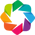

Loading BokehJS ...

In [48]:
import numpy as np
import pandas as pd
import altair as alt
import bokeh.io
import bokeh.layouts
import bokeh.palettes
import bokeh.plotting
import bokeh.application
import bokeh.application.handlers
from bokeh.models import Legend
from bokeh.models import Range1d
import bebi103
import altair_catplot as alt_cat
import re
import scipy.stats as st
import glob
import os
import bebi103
import sys

import holoviews as hv
from holoviews import opts as hvopts

import panel as pn
import hvplot.pandas

hv.extension('bokeh')

bokeh.io.output_notebook()
bebi103.hv.set_defaults()

palette = bokeh.palettes.Colorblind6

##### Write a function to get data files based on date and desired data

In [33]:
def get_data(rel_path, data_type, date, exp_date):
    """
    Function to retrieve desired data: CFUs, electrolysis, ATP, or nitrite.
    This function requires that the data file be in .csv format.
    
    Parameters:
    -----------
    rel_path : str
        The relative path to follow to find the data
    data_type : str
        The piece of data that you want to retrieve. Possible inputs are
        'CFUs', 'EChem', 'ATP', and 'Nitrite'
    date : str
        The date on which the experiment began in the format YYYY_MM_DD.
        Used to find files
    exp_date : str
        The date that I want to use to label the data. In the case of the
        potentiostat data, this is different from the date on which the 
        potentiostat was started because that is a day before inoculation.
        I.e., if the all the CFUs, ATP measurements, etc. begin on 2019_10_20,
        the potentiostat began on 2019_10_19, but I want to label these data
        with the same date. Format YYYY_MM_DD.
        
    Returns:
    --------
    df : pandas DataFrame
        The dataframe containing the desired data
    """

    allowed_data_types = ["CFUs", "EChem", "ATP", "Nitrite"]
    assert (
        data_type in allowed_data_types
    ), f"Your data type is not in {allowed_data_types}"

    # The potentiostat data comes out as .txt files with tab separated columns
    if data_type == "EChem":
        path = os.path.join(rel_path, data_type, f"{date}*.txt")
    else:
        path = os.path.join(rel_path, data_type, f"{date}*.csv")

    files = glob.glob(path)

    # The potentiostat generates up to four data files, one for each lead, but
    # it is critical to check that a single data file is defined by the input
    # for the other measurements because I have had to requantify some data files,
    # and so there are some files that share dates, for example.

    if data_type != "EChem":
        assert (
            len(files) == 1
        ), f"Your input did not define a unique data file for ATP, NO2, or CFU results: {files}"
        
        df = pd.read_csv(files[0])
        
        if data_type == 'CFUs':
            df['chamber'] = [f"Chamber {c}" for c in df["chamber"].values]
            df['exp'] = exp_date
            
            return df
            
        elif data_type == 'ATP':
            df['exp'] = exp_date
            calib_wells = [f'A{i}' for i in range(1,9)]
            calib_wells.insert(0, 'Kinetic read')
            
            column_dict = {'A1': 5000, 
                           'A2': 2500,
                           'A3': 500,
                           'A4': 250,
                           'A5': 50,
                           'A6': 25,
                           'A7': 5,
                           'A8': 0}
            
            atp_calib_dict = get_calib(df, data_type, calib_wells, column_dict)
            measured_atp_df = get_measured_df(df, 
                                              atp_calib_dict['value_name'], 
                                              atp_calib_dict['calib_wells'])
            
            return atp_calib_dict, measured_atp_df
        
        elif data_type == 'Nitrite':
            df['exp'] = exp_date
            
            if exp_date == '2019_08_28':
                calib_wells = [f'B{i}' for i in range(1,7)]
                calib_wells.insert(0, 'Kinetic read')
                
                column_dict = {'B1': 60,
                               'B2': 45,
                               'B3': 30,
                               'B4': 20,
                               'B5': 10,
                               'B6': 0}
            
            else:
                calib_wells = [f'A{i}' for i in range(1,7)]
                calib_wells.insert(0, 'Kinetic read')
                
                column_dict = {'A1': 60,
                               'A2': 45,
                               'A3': 30,
                               'A4': 20,
                               'A5': 10,
                               'A6': 0}
            
            no2_calib_dict = get_calib(df, data_type, calib_wells, column_dict)
            measured_no2_df = get_measured_df(df, 
                                              no2_calib_dict['value_name'], 
                                              no2_calib_dict['calib_wells'])
            
            return no2_calib_dict, measured_no2_df

    # The potentiostat data comes out as .txt files with tab separated columns
    elif data_type == "EChem":
        df_list = []
        for f in files:
            df = pd.read_csv(files[0], delimiter="\t")
            df["lead"] = f[-6:-4]
            df["chamber"] = [f"Chamber {l}" for l in df["lead"].values]
            df = df[["lead", "time (s)", "charge (C)", "current (A)"]]
            df_list.append(df)
        df = pd.concat(df_list)
        df["exp"] = exp_date

        return df

##### Define a function to remove data that should be excluded from analysis, e.g. known experimental errors

In [34]:
def remove_observations(df, chamber, exp):
    """
    Function to remove data that are inappropriate for analysis.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe that has some data that ought to be removed
    chamber : str
        The chamber id to remove
    exp : str
        The experiment date to remove
        
    Returns:
    --------
    cleaned_df : pandas DataFrame
        The dataframe without unwanted observations.
    """
    
    to_remove = df.loc[(df['chamber'] == chamber) & (df['exp'] == exp)]
    
    cleaned_df = df.iloc[df.index.difference(to_remove.index)]
    
    return cleaned_df

##### Define Functions necessary for processing CFU data

In [35]:
def correct_sampling_time(cfu_df, inoculation_ks):
    """
    Function to subtract the inoculation time from the time at which CFUs were sampled.
    This is done because the sampling time is relative to when the potentiostat was turned on,
    which is done the night before inoculation.
    
    Parameters:
    -----------
    cfu_df : pandas DataFrame
        The dataframe with the CFU data
    inoculation_ks: float
        The time, in kiloseconds, when the cells were inoculated. Time reported relative to when
        the potentiostat was turned on.
        
    Returns:
    --------
    cfu_df : pandas DataFrame
        The cfu_df, now with corrected sampling time
    """
    
    cfu_df['time (ks)'] = cfu_df['time (ks)'].values - inoculation_ks
    
    return cfu_df

def convert_ks_to_days(cfu_df):
    """
    Function to convert the kilosecond time scale to the daily time scale.
    
    Parameters:
    -----------
    cfu_df : pandas Dataframe
        The cfu_df with a corrected sampling time (i.e., returned by correct_sampling_time()).
    
    Returns:
    --------
    cfu_df : pandas Dataframe
        The cfu_df, now with a column of time in days.
    """
    
    # 1000 s in 1 ks, 60 s in 1 m, 60 m in 1 hr, 24 hr in 1 d
    cfu_df['time (days)'] = cfu_df['time (ks)'].values * 1000 / (60 * 60 * 24)
    
    return cfu_df

def scale_cell_density(cfu_df):
    """
    Function to scale cell density for ease of thinking.
    
    Parameters:
    -----------
    cfu_df : pandas DataFrame
        cfu_df as returned by convert_ks_to_days()
    
    Returns:
    --------
    cfu_df : pandas DataFrame
        cfu_df, now with a scaled CFU per mL per 1e9 column
    """
    
    cfu_df['scaled density (CFU per mL per 1e9)'] = cfu_df['density (CFU per mL)'].values / 1e9
    
    return cfu_df

def assign_timepoints(cfu_df):
    """
    Function to assign timepoints for each sampling time in a cfu_df. This is done so that
    different cfu_dfs, which have different exact sampling times, can be aligned.
    
    Parameters:
    -----------
    cfu_df : pandas DataFrame
        cfu_df, as returned by scale_cell_density()
    
    Returns:
    --------
    cfu_df : pandas DataFrame
        cfu_df, now with a timepoint column
    """
    
    times = sorted(cfu_df['time (days)'].unique())
    
    timepoint_dict = {t: i for i, t in enumerate(times)}
    cfu_df['timepoint'] = [timepoint_dict[t] for t in cfu_df['time (days)'].values]
    
    return cfu_df

def mean_sampling_time(cfu_df_list):
    """
    Function to determine the mean sampling time for each timepoint
    
    Parameters:
    -----------
    cfu_df_list : list of pandas DataFrames
        List of all cfu_dfs that should be analyzed together (i.e., from the same experimental procedure).
        Each item is a cfu_df, as returned by assign_timepoints().
        
    Returns:
    --------
    cfu_df_concat : pandas DataFrame
        cfu_df_concat, all the cfu data together in one dataframe. 
        Includes the column 'mean sampling time (days)', which helps align the different experiments
    """
    
    cfu_df_concat = pd.concat(cfu_df_list)
    
    grouped = cfu_df_concat.groupby(['timepoint', 'chamber'])
    
    mean_timepoint_dict = {}
    
    for g in grouped:
        
        mean_time = np.mean(g[1]['time (days)'].values)
        mean_timepoint_dict[g[0][0]] = mean_time
        
    cfu_df_concat['mean sampling time (days)'] = [mean_timepoint_dict[t] for t in cfu_df_concat['timepoint']]
    
    return cfu_df_concat

def average_cfu_tech_reps(cfu_df_concat):
    """
    Function to average the technical replicates from a given experiment
    so that biological replicates can be more easily compared
    
    Parameters:
    -----------
    cfu_df_concat : pandas DataFrame
        cfu_df_concat, as returned by mean_sampling_time()
    
    Returns: 
    --------
    cfu_bio_rep_master_df : pandas DataFrame
        Processed CFU data that can be plotted by cfu_plotter()
    """
    
    grouped = cfu_df_concat.groupby(['exp', 'timepoint', 'mean sampling time (days)', 'chamber', 'time (days)'])

    exps = []
    timepoints = []
    mean_times = []
    chambers = []
    real_times = []
    means = []

    for g in grouped:
        exps.append(g[0][0])
        timepoints.append(g[0][1])
        mean_times.append(g[0][2])
        chambers.append(g[0][3])
        real_times.append(g[0][4])
        means.append(np.mean(g[1]['scaled density (CFU per mL per 1e9)']))

    cfu_bio_rep_master_df = pd.DataFrame.from_dict({'exp': exps,
                                                    'timepoint': timepoints,
                                                    'mean sampling time (days)': mean_times,
                                                    'chamber': chambers,
                                                    'time (days)': real_times,
                                                    'mean scaled density (CFU per mL per 1e9)': means})
    
    return cfu_bio_rep_master_df

def assign_color_to_chamber(data_df, palette=bokeh.palettes.Colorblind6):
    """
    Function to assign colors to data points by chamber condition
    """
    
    data_df['color'] = [palette[int(ch[-1])] for ch in data_df['chamber'].values]
    
    return data_df

In [36]:
def cfu_plotter(
    cfu_df,
    palette,
    time_var="time (days)",
    y_type="log",
    title="Electrolysis Survival",
    error=False,
    height=400,
    width=700,
):
    """
    Function to plot CFUs over the duration of the experiment.
    
    Parameters:
    -----------
    cfu_df : pandas DataFrame
        The cfu_df as returned by scale_cell_density()
    
    palette : bokeh color palette
        The color palette to use for plotting
    
    time_var : str
        The time variable to use for plotting. Either 'time (days)' or 'time (ks)'
    
    y_type : str, default 'log'
        Type of scaling on the y-axis
    
    title : str, default 'Electrolysis Survival'
        Title to display over plot
        
    error : Bool, default False
        Determines whether function attempts to draw error bars. This requires the dataframe to have
        ymin and ymax values for the error bars for each data point.
        
    height : int, default 400
        Height of the plot
    
    width : int, default 700
        Width of the plot
        
    Returns:
    --------
    cfu_fig : bokeh figure object
        The resulting figure
    """

    cfu_fig = bokeh.plotting.figure(
        height=height,
        width=width,
        y_axis_type=y_type,
        y_axis_label="Scaled Density (CFU per mL per 1e9)",
        x_axis_label=time_var,
        title=title,
    )

    grouped = cfu_df.groupby(["exp", "chamber"])

    legend_items = []

    for i, g in enumerate(grouped):
        exp = g[0][0]
        ch = g[0][1]
        gdf = g[1]
        ch_index = int(ch[-1])
        if error:
            xs = [(x, x) for x in gdf[time_var]]
            ys = [(y1, y2) for y1, y2 in zip(gdf["ymin"], gdf["ymax"])]

            e = cfu_fig.multi_line(
                xs,
                ys,
                color=palette[i],
                line_width=2,
                muted_color=palette[i],
                muted_alpha=0,
            )
            
            l = cfu_fig.line(
                gdf[time_var],
                gdf["mean scaled density (CFU per mL per 1e9)"],
                color=palette[ch_index],
                line_width=2,
                muted_color=palette[ch_index],
                muted_alpha=0,
            )
            
            c = cfu_fig.circle(
                gdf[time_var],
                gdf["mean scaled density (CFU per mL per 1e9)"],
                color=palette[ch_index],
                size=7,
                fill_alpha=0,
                muted_color=palette[ch_index],
                muted_alpha=0,
            )

        else:
            c = cfu_fig.circle(
                gdf[time_var],
                gdf["mean scaled density (CFU per mL per 1e9)"],
                color=palette[ch_index],
                size=10,
                line_width=5,
                line_alpha=0.8,
                fill_alpha=0,
                muted_color=palette[ch_index],
                muted_alpha=0,
            )
            
            l = cfu_fig.line(
                gdf[time_var],
                gdf["mean scaled density (CFU per mL per 1e9)"],
                color=palette[ch_index],
                line_width=2,
                muted_color=palette[ch_index],
                muted_alpha=0,
            )
            
        if error:
            legend_items.append((f"{ch} {exp}", [l, c, e]))

        else:
            legend_items.append((f"{ch} {exp}", [l, c]))

    legend = Legend(items=legend_items)
    cfu_fig.add_layout(legend, "right")

    cfu_fig.legend.click_policy = "mute"

    cfu_fig.xaxis.axis_label_text_font_size = "16pt"
    cfu_fig.xaxis.major_label_text_font_size = "16pt"

    cfu_fig.yaxis.axis_label_text_font_size = "12pt"
    cfu_fig.yaxis.major_label_text_font_size = "16pt"

    cfu_fig.title.text_font_size = "16pt"

    return cfu_fig

In [37]:
def process_cfus(rel_path, date_list, exp_date_list, inoculation_time_list, palette=bokeh.palettes.Colorblind6):
    """
    Function to process all the CFU data into a plottable form
    
    Parameters:
    -----------
    rel_path : str
        The relative path to follow to find the data
    date_list : list of str
        The dates on which the experiments began in the format YYYY_MM_DD.
        Used to find files
    exp_date_list : list of str
        The date that I want to use to label the data. In the case of the
        potentiostat data, this is different from the date on which the 
        potentiostat was started because that is a day before inoculation.
        I.e., if the all the CFUs, ATP measurements, etc. begin on 2019_10_20,
        the potentiostat began on 2019_10_19, but I want to label these data
        with the same date. Format YYYY_MM_DD.
    inoculation_time_list : list of float
        List of inoculation times to input into correct_sampling_time()
        
    Returns:
    --------
    cfu_bio_rep_master_df : pandas DataFrame
        Processed CFU data as returned by average_cfu_tech_reps()
    """
    
    cfu_df_list = []
    
    for d, ed, it in zip(date_list, exp_date_list, inoculation_time_list):
        cfu_df = get_data(rel_path, 'CFUs', d, ed)
        cfu_df = correct_sampling_time(cfu_df, it)
        cfu_df = convert_ks_to_days(cfu_df)
        cfu_df = scale_cell_density(cfu_df)
        cfu_df = assign_timepoints(cfu_df)
        
        cfu_df_list.append(cfu_df)
    
    cfu_df_concat = mean_sampling_time(cfu_df_list)
    
    cfu_bio_rep_master_df = average_cfu_tech_reps(cfu_df_concat)
    cfu_bio_rep_master_df = assign_color_to_chamber(cfu_bio_rep_master_df, palette)
    
    return cfu_bio_rep_master_df

##### The inoculation times for 2019_10_20, 2019_11_11, and 2019_12_02 (the experiments I am currently analyzing)

2019_08_28: 13.51 ks

2019_10_07: 85.75 ks

2019_10_20: 68.6 ks

2019_11_11: 78.8 ks

2019_12_02: 87.0 ks

In [38]:
date_list = ['2019_08_28', '2019_10_07', '2019_10_20', '2019_11_11', '2019_12_02']
exp_date_list = ['2019_08_28', '2019_10_07', '2019_10_20', '2019_11_11', '2019_12_02']
inoculation_time_list = [13.51, 85.75, 68.6, 78.8, 87.0]

In [39]:
cfu_bio_rep_master_df = process_cfus('./data/', date_list, exp_date_list, inoculation_time_list)

##### The chamber 5 from 2019_12_02 ended up being abiotic because I spilled a volume of cells on accident, so I am removing it from the data set

In [40]:
to_remove = cfu_bio_rep_master_df.loc[(cfu_bio_rep_master_df['chamber'] == 'Chamber 5') & (cfu_bio_rep_master_df['exp'] == '2019_12_02')]
to_remove

exp  timepoint  mean sampling time (days)    chamber  time (days)  \
149  2019_12_02          0                   0.003565  Chamber 5     0.003472   
155  2019_12_02          1                   0.171736  Chamber 5     0.107639   
161  2019_12_02          2                   0.745833  Chamber 5     0.802083   
167  2019_12_02          3                   1.892454  Chamber 5     1.891204   
173  2019_12_02          4                   2.955185  Chamber 5     2.978009   
179  2019_12_02          5                   3.887593  Chamber 5     3.910880   

     mean scaled density (CFU per mL per 1e9)    color  
149                              0.000000e+00  #D55E00  
155                              3.266667e-05  #D55E00  
161                              8.000000e-06  #D55E00  
167                              1.833333e-06  #D55E00  
173                              6.666667e-08  #D55E00  
179                              6.666667e-07  #D55E00

In [41]:
cfu_analyzed = cfu_bio_rep_master_df.iloc[cfu_bio_rep_master_df.index.difference(to_remove.index)]

In [49]:
p = cfu_plotter(cfu_analyzed, palette, height=700, width=800)
bokeh.io.show(p)

In [43]:
# def get_ATP_df(date, path='../../../data/PlateReader/ATP'):
    
#     # Get data
#     path_to_data = os.path.join(path, f'{date}_EChemSurvival_ATP.csv')
#     df = pd.read_csv(path_to_data)
#     df['exp'] = date
        
#     return df

def get_calib(df, data_type, calib_wells, column_dict, verbose=True):
    """
    Function to extract calibration data from the ATP_df or NO2_df
    that was read from the plate-reader data
    
    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame object created while running get_data()
        with an ATP or NO2 data_type parameter
    data_type : str
        'ATP' or 'NO2', given as a parameter to get_data()
    verbose: Boolean
        Determines whether to print out the linear regression
        stats when the function is called
    
    Returns:
    --------
    calib_dict : dictionary
        items: ['slope': the slope of the linear regression (float),
                'intercept': the intercept of the linear regression (float),
                'r': the r value of the linear regression (float),
                'p-value': the p-value of the linear regression (float),
                'stderr': the standard error of the linear regression (float),
                'plot': the Bokeh plot of the calibration points and linear regression.]
    """
    
    date = df['exp'].unique()
    
    assert(
        len(date) == 1
          ), f'You are trying to calibrate over more than one experiment, which is wrong. Experiments: {date}'
    
    date = date[0]
    
    # Extract calibration data
    if data_type == 'ATP':
#         calib_wells = ['A{}'.format(i) for i in range(1,9)]
#         calib_wells.insert(0, 'Kinetic read')
        calib_df = df[calib_wells]
#         column_dict = {'A1': 5000, 
#                        'A2': 2500,
#                        'A3': 500,
#                        'A4': 250,
#                        'A5': 50,
#                        'A6': 25,
#                        'A7': 5,
#                        'A8': 0}
        
        var_name = 'ATP (nM)' 
        value_name = 'luminescence (AU)'
    
    elif data_type == 'Nitrite':
#         calib_wells = [f'A{i}' for i in range(1,7)]
#         calib_wells.insert(0, 'Kinetic read')
        calib_df = df[calib_wells]
#         column_dict = {'A1': 60,
#                        'A2': 45,
#                        'A3': 30,
#                        'A4': 20,
#                        'A5': 10,
#                        'A6': 0}
        
        var_name = 'NO2 (uM)'
        value_name = 'absorbance (540 nm)'
    
    # Assign concentrations to wells in nM
    calib_df = calib_df.rename(columns=column_dict)

    # Make tidy
    calib_df = calib_df.melt(id_vars='Kinetic read', var_name=var_name, value_name=value_name)
    
    # Get the maximum luminescence associated with each concentration
    calib_grouped = calib_df.groupby(var_name)
    concs = []
    max_vals = []

    for cg in calib_grouped:
        conc = cg[0]
        df = cg[1]

        val = df[value_name].values
        max_val = np.max(val)

        concs.append(conc)
        max_vals.append(max_val)
        
    
    # Plot to see if calibration is reasonable
    cal_plot = bokeh.plotting.figure(width=600,
                                     height=400,
                                     x_axis_label=var_name,
                                     y_axis_label=value_name,
                                     title=f'{data_type} cal {date}')

    cal_plot.circle(concs, max_vals)
    
    # Get the linear regression
    slope, inter, r, pval, stderr = st.linregress(concs, max_vals)
    
    cal_plot.line(np.array(concs), 
                      np.array(concs) * slope + inter, 
                      color='orange',
                      line_width=2)
    
#     label = bokeh.models.Label(text=f"""
#         ATP calibration curve linear regression
#         ---------------------------------------
#         Slope: {atp_slope}
#         Intercept: {atp_int}
#         R^2: {atp_r ** 2}
#         ---------------------------------------
#         """,
#                               x=600,
#                               y=0)
    
#     atp_cal_plot.add_layout(label)
    
    if verbose:
        print(f"""
        {data_type} calibration curve linear regression
        ---------------------------------------
        Slope: {slope}
        Intercept: {inter}
        R^2: {r ** 2}
        ---------------------------------------
        """)
    
    calib_dict = {'slope': slope,
                  'intercept': inter,
                  'r': r,
                  'p-value': pval,
                  'stderr': stderr,
                  'calib_df': calib_df,
                  'plot': cal_plot,
                  'value_name': value_name,
                  'var_name': var_name,
                  'calib_wells': calib_wells}
    
    return calib_dict
    
def lin_reg_inference(slope, intercept, measured_y):
    """
    Function to infer the x-value corresond to the measured
    y-value, based on the linear regression of a calibration
    curve.
    
    Parameters:
    -----------
    slope : float
        The slope of the linear regression of a calibration curve
    intercept : float
        The intercept of the linear regression of a calibration curve
    measured_y : float
        The y_value that was measured
    
    Returns:
    --------
    (measured_y - intercept) / slope : float
        The inferred x-value
    """

    return (measured_y - intercept) / slope

def get_measured_df(df, value_name, calib_wells):
    """
    Function to extract a DataFrame of only the experimental values from
    a platereader ATP luciferase assay or the NO2 Greiss assy.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The full pandas DataFrame as created by get_data() when given
        the ATP or NO2 data_type parameter
    calib_wells : list of str, default ['A{}'.format(i) for i in range(1,9)]
        The well IDs, which are column headers in ATP_df, that correspond
        to the calibration points
    
    Returns:
    --------
    measured_df : pandas DataFrame
        A tidy dataframe with only the data corresponding to experimental
        samples
    """
    
    # Disregard the data corresponding to the calibration wells,
    # but keep the Kinetic Read column
    measured_df = df[df.columns.difference(calib_wells[1:])]
    
    # Begin tidying
    measured_df = measured_df.melt(id_vars=['exp', 'Kinetic read'], var_name='chamber', value_name=value_name)
    
    # Separate row and column IDs
    measured_df['row'] = [s[0] for s in measured_df['chamber'].values]
    measured_df['column'] = [s[1:] for s in measured_df['chamber'].values]
    
    # Assign chamber IDs, accounting for whether samples were in
    # left or right half of the 96-well plate
    if '1' in measured_df['column'].values:
        measured_df['chamber'] = [f'Chamber {int(s[1:]) - 1}' for s in measured_df['chamber'].values]
        
    else:
        measured_df['chamber'] = [f'Chamber {int(s[1:]) - 7}' for s in measured_df['chamber'].values]
    
    
    # Only interested in the max luminescence intensity for each well
    measured_grouped = measured_df.groupby(['chamber', 'row'])
    
    rows = []
    chambers = []
    measured_max_vals = []

    for mg in measured_grouped:
        chamber, row = mg[0]
        df = mg[1]

        vals = df[value_name].values
        measured_max_vals.append(np.max(vals))
        chambers.append(chamber)
        rows.append(row)
    
    
    measured_df = pd.DataFrame.from_dict({'chamber': chambers,
                                          'row': rows,
                                          f'max {value_name}': measured_max_vals})
    
    measured_df['exp'] = df['exp'].values[0]
    
    return measured_df
        
def infer_concs(measured_df, slope, intercept, data_type, val_name, dilution_factor=1, scaling_factor=1):
    """
    Function to infer the ATP concentration from measured
    luminescence intensities or NO2 concentration from measured
    absorbance
    
    Parameters:
    -----------
    measured_ATP_df : pandas DataFrame
        The measured_ATP_df as returned by assign_sample_time_to_ATP_df()
    slope : float
        The slope from the calib_dict returned by get_calib()
    intercept : float
        The int from the calib_dict returned by get_calib()
        
    Returns:
    --------
    measured_df : pandas DataFrame
        measured_df, now with ATP concentration measurements
    """
    
    vals = measured_df[val_name].values
    
    # Samples were diluted 1:50 when taken from chambers (20 uL in 1 mL), but so were the standards, so no correction needed
    inferred_vals = lin_reg_inference(slope, intercept, vals)
    undiluted_inferred_vals = inferred_vals * dilution_factor
    
    if data_type == 'ATP':
        measured_df['ATP (nM)'] = undiluted_inferred_vals
        # Chambers have 100 mL
        measured_df['ATP (nmol)'] = measured_df['ATP (nM)'].values * 0.1
        
    if data_type == 'Nitrite':
        measured_df['NO2 (uM)'] = undiluted_inferred_vals
        measured_df['NO2 (mM)'] = undiluted_inferred_vals / scaling_factor
    
    return measured_df

def assign_sample_time_to_df(measured_df, cfu_df):
    """
    Function to align the sampling times across the CFU and ATP data
    
    Parameters:
    -----------
    measured_atp_df : pandas DataFrame
        The dataframe of ATP data as returned by infer_atp_concs()
    
    cfu_df : pandas DataFrame
        The dataframe of ATP data as returned by process_cfus()
    
    Returns:
    --------
    measured_atp_df : pandas DataFrame
        measured_atp_df, now with sampling times corresponding to the cfu_df
    """
    
    assert(
        len(measured_df) == len(cfu_df)
    ), 'You are trying to align dataframes of two different lengths'
    
    # Ensure that all the observations are in the same order
    measured_df = measured_df.sort_values(['exp', 'chamber', 'row'])
    cfu_df = cfu_df.sort_values(['exp', 'chamber', 'timepoint'])
    
    
    measured_df['time (days)'] = cfu_df['time (days)'].values
    measured_df['mean sampling time (days)'] = cfu_df['mean sampling time (days)'].values
    
#     cfu_df = cfu_df.loc[all_exps_cfu_mean_df['exp'].isin(measured_atp_df['exp'])]
    
#     grouped_ATP = measured_atp_df.groupby(['exp', 'chamber', 'row'])
#     grouped_cfu = cfu_df.groupby(['exp', 'chamber', 'time (days)'])
    
#     ATP_mini_dfs = []
    
#     for ga, gc in zip(grouped_ATP, grouped_cfu):
        
#         atp_gdf = ga[1].sort_values('row')
#         cfu_gdf = gc[1].sort_values('time (days)')
        
#         atp_gdf['time (days)'] = cfu_gdf['time (days)'].values
        
#         ATP_mini_dfs.append(atp_gdf)
        
    
#     measured_atp_df = pd.concat(ATP_mini_dfs)
    
    return measured_df

def normalize_atp_to_cell_density(measured_atp_df, cfu_df):
    """
    Function to normalize ATP concentration measurements to cell density
    
    Parameters:
    -----------
    measured_atp_df : pandas DataFrame
        measured_atp_df as returned by assign_sample_time_to_ATP_df()
    
    cfu_df : pandas DataFrame
        The dataframe of CFU data that was used in assign_sample_time_to_ATP_df()
    
    Returns:
    --------
    concat_cfu_atp_df : pandas DataFrame
        A horizontally concatenated dataframe including all the CFU and ATP data, including
        a normalized ATP column
    """
    
    # Make sure that all the observations are sorted in the same way
#     measured_atp_df = measured_atp_df.sort_values(by=['exp', 'chamber', 'row'])
#     cfu_df = cfu_df.sort_values(by=['exp', 'chamber', 'timepoint'])
# #     pdb.set_trace()
#     # Reset indices to make sure that the concatenation works
#     measured_atp_df = measured_atp_df.reset_index(drop=True)
#     cfu_df = cfu_df.reset_index(drop=True)
    
#     # Concatenate horizontally and remove duplicate columns
#     concat_cfu_atp_df = pd.concat([cfu_df, measured_atp_df], axis=1)
    
    
#     concat_cfu_atp_df = concat_cfu_atp_df[concat_cfu_atp_df.columns.difference(['row'])]

    cfu_atp_df = cfu_df.merge(measured_atp_df, on=['exp', 'time (days)', 'chamber'])
    # cfu_atp_df = cfu_atp_df.T.drop_duplicates().T
    # cfu_atp_df = cfu_atp_df[cfu_atp_df.columns.difference(['row'])]
    
    # Normalize
    cfu_atp_df['normalized ATP (nmol / CFU / 1e9)'] = (cfu_atp_df['ATP (nmol)'].values / (cfu_atp_df['mean scaled density (CFU per mL per 1e9)'].values * 100))
    
    return cfu_atp_df

def process_atp_no2(rel_path, date_list, exp_date_list, cfu_master_df):
    """
    Function to process all the ATP data into a plottable form
    
    Parameters:
    -----------
    rel_path : str
        The relative path to follow to find the data
    date_list : list of str
        The dates on which the experiments began in the format YYYY_MM_DD.
        Used to find files
    exp_date_list : list of str
        The date that I want to use to label the data. In the case of the
        potentiostat data, this is different from the date on which the 
        potentiostat was started because that is a day before inoculation.
        I.e., if the all the CFUs, ATP measurements, etc. begin on 2019_10_20,
        the potentiostat began on 2019_10_19, but I want to label these data
        with the same date. Format YYYY_MM_DD.
    cfu_master_df : pandas DataFrame
        The dataframe of CFU data as returned by process_cfus()
        
    Returns:
    --------
    cfu_atp_master_df : pandas DataFrame
        Processed ATP data as returned by normalize_atp_to_cell_density()
    """
    
    cfu_atp_no2_df_list = []
    
    for d, ed, it in zip(date_list, exp_date_list, inoculation_time_list):

        atp_calib_df, measured_atp_df = get_data(rel_path, 'ATP', d, ed)
        atp_slope = atp_calib_df['slope']
        atp_int = atp_calib_df['intercept']
        cfu_df = cfu_master_df.loc[cfu_master_df['exp'] == ed]
        measured_atp_df = infer_concs(measured_atp_df, 
                                      atp_slope, 
                                      atp_int, 
                                      'ATP', 
                                      'max luminescence (AU)', 
                                      dilution_factor=1, 
                                      scaling_factor=1)
        
        no2_calib_df, measured_no2_df = get_data(rel_path, 'Nitrite', d, ed)
        no2_slope = no2_calib_df['slope']
        no2_int = no2_calib_df['intercept']
        cfu_df = cfu_master_df.loc[cfu_master_df['exp'] == ed]
        measured_no2_df = infer_concs(measured_no2_df, 
                                      no2_slope, 
                                      no2_int, 
                                      'Nitrite', 
                                      'max absorbance (540 nm)', 
                                      dilution_factor=200, 
                                      scaling_factor=1000)
        
        # When I requantified the samples from 2019_10_20 because my Bactiter Glo
        # was too old when I did it the first time, I used row B to run samples
        # from 2019_10_07-2019_10_11 to verify that the requanitfication was valid.
        # I need to remove this row from the analysis, however.
        
        # Likewise, when I ran the experiment from 2019_12_02-2019_12_06, Chamber 5
        # ended up being abiotic. I also need to exclude it from the analysis.
        
        if ed == '2019_10_20':
            measured_atp_df = measured_atp_df.loc[measured_atp_df['row'] != 'B']
            
        elif ed == '2019_12_02':
            measured_atp_df = measured_atp_df.loc[measured_atp_df['chamber'] != 'Chamber 5']
            measured_no2_df = measured_no2_df.loc[measured_no2_df['chamber'] != 'Chamber 5']
            cfu_df = cfu_df.loc[cfu_df['chamber'] != 'Chamber 5']
        
#         measured_atp_df = measured_atp_df[measured_atp_df.columns.difference(['row'])]
#         measured_no2_df = measured_no2_df[measured_no2_df.columns.difference(['row'])]
        
        measured_atp_df = assign_sample_time_to_df(measured_atp_df, cfu_df)
        measured_no2_df = assign_sample_time_to_df(measured_no2_df, cfu_df)
        
        cfu_atp_df = normalize_atp_to_cell_density(measured_atp_df, cfu_df)
        
        cfu_atp_no2_df = cfu_atp_df.merge(measured_no2_df, on=['exp', 'chamber', 'time (days)'])
        
        # concat_cfu_atp_no2_df = pd.concat([concat_cfu_atp_df, measured_no2_df], axis=1)
#         concat_cfu_atp_no2_df = concat_cfu_atp_no2_df.T.drop_duplicates().T
        
#         concat_cfu_atp_no2_df = concat_cfu_atp_no2_df[concat_cfu_atp_no2_df.columns.difference(['row'])]
        
        cfu_atp_no2_df_list.append(cfu_atp_no2_df)
    
    cfu_atp_no2_master_df = pd.concat(cfu_atp_no2_df_list)
    
    return cfu_atp_no2_master_df

In [44]:
cfu_atp_no2_master_df = process_atp_no2('./data/', date_list, exp_date_list, cfu_bio_rep_master_df)


        ATP calibration curve linear regression
        ---------------------------------------
        Slope: 30.236792050511013
        Intercept: 563.190277405407
        R^2: 0.9997851976864303
        ---------------------------------------
        

        Nitrite calibration curve linear regression
        ---------------------------------------
        Slope: 0.050128643216080404
        Intercept: 0.13446231155778876
        R^2: 0.9991076565801764
        ---------------------------------------
        

        ATP calibration curve linear regression
        ---------------------------------------
        Slope: 30.26151068903325
        Intercept: 305.4519950441281
        R^2: 0.9999768440782568
        ---------------------------------------
        

        Nitrite calibration curve linear regression
        ---------------------------------------
        Slope: 0.04692060301507536
        Intercept: 0.18468341708542746
        R^2: 0.9993080786230475
        --------

In [45]:
cfu_atp_no2_master_df.head()

exp  timepoint  mean sampling time (days)_x    chamber  time (days)  \
0  2019_08_28          0                     0.003565  Chamber 0     0.007755   
1  2019_08_28          0                     0.003565  Chamber 1     0.007755   
2  2019_08_28          0                     0.003565  Chamber 2     0.007755   
3  2019_08_28          0                     0.003565  Chamber 3     0.007755   
4  2019_08_28          0                     0.003565  Chamber 4     0.007755   

   mean scaled density (CFU per mL per 1e9)    color row_x  \
0                                  0.780000  #0072B2     B   
1                                  0.773333  #E69F00     B   
2                                  0.880000  #F0E442     B   
3                                  0.790000  #009E73     B   
4                                  0.843333  #56B4E9     B   

   max luminescence (AU)     ATP (nM)  ATP (nmol)  \
0                  43146  1408.311095  140.831110   
1                  39061  1273.210784  127.321078   
2                  52051  1702.819851  170.281985   
3                  47943  1566.958877  156.695888   
4                  52601  1721.009611  172.100961   

   mean sampling time (days)_y  normalized ATP (nmol / CFU / 1e9) row_y  \
0                     0.003565                           1.805527     C   
1                     0.003565                           1.646393     C   
2                     0.003565                           1.935023     C   
3                     0.003565                           1.983492     C   
4                     0.003565                           2.040723     C   

   max absorbance (540 nm)    NO2 (uM)  NO2 (mM)  mean sampling time (days)  
0                    0.238  413.087935  0.413088                   0.003565  
1                    0.214  317.334296  0.317334                   0.003565  
2                    0.240  421.067404  0.421067                   0.003565  
3                    0.252  468.944224  0.468944                   0.003565  
4                    0.280  580.656803  0.580657                   0.003565

In [50]:
df_for_paper = cfu_atp_no2_master_df.loc[cfu_atp_no2_master_df['chamber'].isin(['Chamber 0', 'Chamber 1'])]

In [105]:

def plot_grids(df, y, y_range=(1e-5, 1e1), semilog=True, legend_position='bottom_left'):
    plots = []
    
    condition_dict = {
        "Chamber 0": "PCA + electrode",
        "Chamber 1": "electrode",
        "Chamber 2": "PCA + acetate + electrode",
        "Chamber 3": "acetate + electrode",
        "Chamber 4": "PCA + acetate",
        "Chamber 5": "acetate"
    }

    if semilog:
        plot = bokeh.plotting.figure(width=400, 
                                         height=300, 
                                         y_axis_type='log', 
                                         y_axis_label=y,
                                         x_axis_label='Time (days)'
                                         # title=condition_dict[chamber],
                                        )
    else:
        plot = bokeh.plotting.figure(width=400, 
                                         height=300, 
                                         y_axis_label=y,
                                         x_axis_label='Time (days)'
                                         # y_axis_type='log', 
                                         # title=condition_dict[chamber],
                                        )
    grouped = df.groupby(['chamber'])
    palette = [bokeh.palettes.Colorblind4[3], 'gainsboro']
    for g in grouped:
        chamber = g[0]
        


        plot.circle(g[1]['time (days)'], g[1][y], color=palette[int(chamber[-1])], line_color='black', size=7, alpha=0.7, line_alpha=1, legend_label=condition_dict[chamber])
        
        exp_grouped = g[1].groupby('exp')
        for eg in exp_grouped:
            plot.line(eg[1]['time (days)'], eg[1][y], line_color=palette[int(chamber[-1])], width=2, alpha=0.7)

        plot.y_range = Range1d(y_range[0], y_range[1])
        plot.xaxis.major_label_text_font_size = '12pt'
        plot.yaxis.major_label_text_font_size = '12pt'
        plot.title.text_font_size = '12pt'
        plot.legend.location = legend_position
        
        plot.output_backend = 'svg'
        
        plots.append(plot)


    return plots

In [106]:
cfu_plots = plot_grids(df_for_paper, 'mean scaled density (CFU per mL per 1e9)')
cfu_grid = bokeh.layouts.gridplot(cfu_plots, ncols=2)
bokeh.io.export_svg(cfu_grid, filename='./plots/cfu_gridplot.svg')
bokeh.io.show(cfu_grid)

ERROR:bokeh.core.validation.check:E-1027 (REPEATED_LAYOUT_CHILD): The same model can't be used multiple times in a layout: GridPlot(id='p604162', ...)
ERROR:bokeh.core.validation.check:E-1027 (REPEATED_LAYOUT_CHILD): The same model can't be used multiple times in a layout: GridPlot(id='p604162', ...)


In [107]:
atp_plots = plot_grids(df_for_paper, 'normalized ATP (nmol / CFU / 1e9)', y_range=(1e-3, 3))
atp_grid = bokeh.layouts.gridplot(atp_plots, ncols=2)
bokeh.io.export_svg(atp_grid, filename='./plots/atp_gridplot.svg')
bokeh.io.show(atp_grid)

ERROR:bokeh.core.validation.check:E-1027 (REPEATED_LAYOUT_CHILD): The same model can't be used multiple times in a layout: GridPlot(id='p607869', ...)
ERROR:bokeh.core.validation.check:E-1027 (REPEATED_LAYOUT_CHILD): The same model can't be used multiple times in a layout: GridPlot(id='p607869', ...)


In [108]:
no2_plots = plot_grids(df_for_paper, 'NO2 (mM)', y_range=(-1, 12), semilog=False, legend_position='bottom_right')
no2_grid = bokeh.layouts.gridplot(no2_plots, ncols=2)
bokeh.io.export_svg(no2_grid, filename='./plots/no2_gridplot.svg')
bokeh.io.show(no2_grid)

ERROR:bokeh.core.validation.check:E-1027 (REPEATED_LAYOUT_CHILD): The same model can't be used multiple times in a layout: GridPlot(id='p611645', ...)
ERROR:bokeh.core.validation.check:E-1027 (REPEATED_LAYOUT_CHILD): The same model can't be used multiple times in a layout: GridPlot(id='p611645', ...)


In [122]:
t2 = df_for_paper.loc[df_for_paper['timepoint'] == 2]

In [123]:
t2

exp  timepoint  mean sampling time (days)_x    chamber  \
12  2019_08_28          2                     0.745833  Chamber 0   
13  2019_08_28          2                     0.745833  Chamber 1   
12  2019_10_07          2                     0.745833  Chamber 0   
13  2019_10_07          2                     0.745833  Chamber 1   
12  2019_10_20          2                     0.745833  Chamber 0   
13  2019_10_20          2                     0.745833  Chamber 1   
12  2019_11_11          2                     0.745833  Chamber 0   
13  2019_11_11          2                     0.745833  Chamber 1   
10  2019_12_02          2                     0.745833  Chamber 0   
11  2019_12_02          2                     0.745833  Chamber 1   

    time (days)  mean scaled density (CFU per mL per 1e9)    color row_x  \
12     0.721644                                  0.996667  #0072B2     D   
13     0.721644                                  1.036667  #E69F00     D   
12     0.705440                                  1.250000  #0072B2     D   
13     0.705440                                  1.070000  #E69F00     D   
12     0.741898                                  1.096667  #0072B2     E   
13     0.741898                                  1.106667  #E69F00     E   
12     0.758102                                  1.313333  #0072B2     D   
13     0.758102                                  0.936667  #E69F00     D   
10     0.802083                                  1.180000  #0072B2     D   
11     0.802083                                  1.180000  #E69F00     D   

    max luminescence (AU)     ATP (nM)  ATP (nmol)  \
12                  10885   341.365900   34.136590   
13                  10137   316.627826   31.662783   
12                  29265   956.976283   95.697628   
13                  22275   725.989797   72.598980   
12                  31979   981.733922   98.173392   
13                  16994   515.468892   51.546889   
12                  42186  1371.090054  137.109005   
13                  28315   912.755371   91.275537   
10                  23443   490.250043   49.025004   
11                  21018   437.746793   43.774679   

    mean sampling time (days)_y  normalized ATP (nmol / CFU / 1e9) row_y  \
12                     0.745833                           0.342508     E   
13                     0.745833                           0.305429     E   
12                     0.745833                           0.765581     D   
13                     0.745833                           0.678495     D   
12                     0.745833                           0.895198     D   
13                     0.745833                           0.465785     D   
12                     0.745833                           1.043977     D   
13                     0.745833                           0.974472     D   
10                     0.745833                           0.415466     D   
11                     0.745833                           0.370972     D   

    max absorbance (540 nm)     NO2 (uM)  NO2 (mM)  mean sampling time (days)  
12                    1.061  3696.639801  3.696640                   0.745833  
13                    0.796  2639.360038  2.639360                   0.745833  
12                    1.199  4323.544532  4.323545                   0.745833  
13                    0.854  2852.975196  2.852975                   0.745833  
12                    1.219  4408.794928  4.408795                   0.745833  
13                    0.919  3130.038984  3.130039                   0.745833  
12                    1.704  6187.613002  6.187613                   0.745833  
13                    1.193  4144.762747  4.144763                   0.745833  
10                    1.285  4524.548891  4.524549                   0.745833  
11                    1.086  3731.164269  3.731164                   0.745833

In [126]:
bootstrap_hypothesis_test_mean(t2.loc[t2['chamber'] == 'Chamber 0']['NO2 (mM)'].values, t2.loc[t2['chamber'] == 'Chamber 1']['NO2 (mM)'].values) * 6

0.017592

In [140]:
def bootstrap_survival_exps(df, measurement, reps=1000000):
    """
    Function that returns bonferroni-corrected p-value for each timepoint for a given metric.
    """
    
    timepoint_bonferroni_dict = {}
    
    timepoint_grouped = df.groupby('timepoint')
    
    for tg in timepoint_grouped:
        tp = tg[0]
        
        set1 = tg[1].loc[tg[1]['chamber'] == 'Chamber 0'][measurement].values
        set2 = tg[1].loc[tg[1]['chamber'] == 'Chamber 1'][measurement].values

        bonferroni = bootstrap_hypothesis_test_mean(set1, set2, reps) * len(timepoint_grouped)
        
        timepoint_bonferroni_dict[tp] = bonferroni
        
    return timepoint_bonferroni_dict

In [137]:
bootstrap_survival_exps(df_for_paper, 'NO2 (mM)')

{0: 5.28612,
 1: 0.12452400000000001,
 2: 0.01761,
 3: 0.011934,
 4: 5.86434,
 5: 2.041254}

In [138]:
bootstrap_survival_exps(df_for_paper, 'normalized ATP (nmol / CFU / 1e9)')

{0: 4.443516,
 1: 5.135076,
 2: 2.5222860000000003,
 3: 0.20288399999999998,
 4: 0.309066,
 5: 3.413832}

In [139]:
bootstrap_survival_exps(df_for_paper, 'mean scaled density (CFU per mL per 1e9)')

{0: 3.256878,
 1: 2.430762,
 2: 0.604554,
 3: 0.722616,
 4: 2.030466,
 5: 0.015539999999999998}

In [198]:
0.05/ 6

0.008333333333333333

#### Getting current traces

In [60]:
def current_plotter(df, palette, title='Current during electrolysis', show_legend=True, width=400, height=300):
    
    condition_dict = {
        0: "PCA + electrode",
        1: "electrode",
        2: "PCA + acetate + electrode",
        3: "acetate + electrode",
        4: "PCA + acetate",
        5: "acetate"
    }
    
    plots = []

    chamber_grouped = df.groupby(['chamber'])

    legend_items = []
    
    current_fig = bokeh.plotting.figure(height=height,
                                    width=width,
                                    # y_axis_type='log',
                                    y_axis_label='Current (µA)',
                                    x_axis_label='Time (days)',
                                    # title=condition_dict[int(ch)]
                                   )

    for i, g in enumerate(chamber_grouped):
        
        
        
        # exp = g[0][0]
        ch = g[0]
        gdf = g[1]
        

        
        exp_grouped = gdf.groupby(['exp'])
        
        for eg in exp_grouped:
            
            e_df = eg[1]

            l = current_fig.line(e_df['time (days)'], 
                                 e_df['current (uA)'], 
                                 color=palette[int(ch)], 
                                 alpha=0.7, 
                                 line_width=3, 
                                 muted_color=palette[int(ch)],
                                 muted_alpha=0.1,
                                 legend_label=condition_dict[int(ch)])
            
        current_fig.output_backend = 'svg'
        current_fig.xaxis.major_label_text_font_size = '12pt'
        current_fig.yaxis.major_label_text_font_size = '12pt'
        current_fig.xaxis.axis_label_text_font_size = '12pt'
        current_fig.yaxis.axis_label_text_font_size = '12pt'
        current_fig.title.text_font_size = '12pt'
        
        current_fig.y_range = Range1d(-10, 2.5e2)
        
        
        plots.append(current_fig)
        
        
#         legend_items.append((f'Chamber {int(ch)} {exp}', [l]))
        
#         if show_legend:
#             legend = Legend(items=legend_items)

#             current_fig.add_layout(legend, 'right')
#             current_fig.legend.click_policy = 'mute'

#         else:
#             pass


    
    return plots

In [61]:
def get_potentiostat_df(date, inoculation_ks, path='./data/EChem'):
    
    dfs = []
    
    for p in ['p0', 'p1', 'p2', 'p3']:
        path_to_data = os.path.join(path, f'{date}_electrolysis_survival_{p}.txt')
        df = pd.read_csv(path_to_data, delimiter='\t')
        df['chamber'] = p[1]
        df['exp'] = date
        
        dfs.append(df)
    
    poten_df = pd.concat(dfs)
    poten_df = poten_df[['exp', 'chamber', 'time (s)', 'charge (C)', 'current (A)']]
    
    poten_df['time (s)'] = poten_df['time (s)'] - inoculation_ks * 1000
    
    poten_df['time (days)'] = poten_df['time (s)'] / (60 * 60 * 24)
    poten_df['current (uA)'] = poten_df['current (A)'] * 1e6

        
        
    return poten_df

def get_spiking_potentiostat_df(date, inoculation_ks, path='./data/EChem'):
    
    dfs = []
    
    for p in ['p0', 'p1', 'p2', 'p3']:
        path_to_data = os.path.join(path, f'{date}_EChemSurvival_Spiking_{p}.txt')
        df = pd.read_csv(path_to_data, delimiter='\t')
        df['chamber'] = p[1]
        df['exp'] = date
        
        dfs.append(df)
    
    poten_df = pd.concat(dfs)
    poten_df = poten_df[['exp', 'chamber', 'time (s)', 'charge (C)', 'current (A)']]
    
    poten_df['time (s)'] = poten_df['time (s)'] - inoculation_ks * 1000
    
    poten_df['time (days)'] = poten_df['time (s)'] / (60 * 60 * 24)
    poten_df['current (uA)'] = poten_df['current (A)'] * 1e6

        
        
    return poten_df

In [62]:
test = get_potentiostat_df('2019_08_28', inoculation_time_list[0])
test.head()

exp chamber  time (s)  charge (C)  current (A)  time (days)  \
0  2019_08_28       0  -13510.0    0.007352     0.001470    -0.156366   
1  2019_08_28       0  -13505.0    0.011880     0.000906    -0.156308   
2  2019_08_28       0  -13500.0    0.003162     0.001744    -0.156250   
3  2019_08_28       0  -13495.0   -0.002038     0.001040    -0.156192   
4  2019_08_28       0  -13490.0   -0.005598     0.000712    -0.156134   

   current (uA)  
0        1470.0  
1         905.8  
2        1744.0  
3        1040.0  
4         712.1

In [63]:
test_plot = current_plotter(test.loc[test['time (days)'] >= 0][::200], bokeh.palettes.Colorblind6)
bokeh.io.show(test_plot[0])

In [64]:
# The potentiostat files are usually dated a day earlier than the CFU, ATP, and NO2 files
# because the potentiostat was set to pre-reduce the PCA a day earlier

potentiostat_dates = ['2019_08_28', '2019_10_06', '2019_10_19', '2019_11_10', '2019_12_01']

poten_dfs = []

for i, d in enumerate(potentiostat_dates):
    
    p_df = get_potentiostat_df(d, inoculation_time_list[i])
    p_df = p_df.loc[p_df['time (days)'] >= 0][::200]
    
    poten_dfs.append(p_df)

current_df = pd.concat(poten_dfs)
current_df.head()

exp chamber  time (s)  charge (C)  current (A)  time (days)  \
2702  2019_08_28       0       0.0    -0.01331     0.000001     0.000000   
2902  2019_08_28       0    1000.0    -0.02973     0.000050     0.011574   
3102  2019_08_28       0    2000.0    -0.11910     0.000111     0.023148   
3302  2019_08_28       0    3000.0    -0.23630     0.000119     0.034722   
3502  2019_08_28       0    4000.0    -0.35490     0.000117     0.046296   

      current (uA)  
2702         1.184  
2902        49.720  
3102       110.800  
3302       119.300  
3502       117.200

In [109]:
current_plots = current_plotter(current_df.loc[current_df['chamber'].isin(['0', '1']) & (current_df['time (days)'] <= 4)], [bokeh.palettes.Colorblind4[3], 'gainsboro'], width=435, height=300)
bokeh.io.export_svg(current_plots[0], filename='./plots/current_plot.svg')
bokeh.io.show(current_plots[0])

In [67]:
def spike_current_plotter(df, palette, title='Current during electrolysis', show_legend=True, width=800, height=400, spike_times=np.array([])):
    
    current_fig = bokeh.plotting.figure(height=height,
                                width=width,
                                # y_axis_type='log',
                                y_axis_label='Current (µA)',
                                x_axis_label='Time (days)',
                                title=title)

    grouped = df.groupby(['exp', 'chamber'])

    legend_items = []

    for i, g in enumerate(grouped):
        exp = g[0][0]
        ch = g[0][1]
        gdf = g[1]

        l = current_fig.line(gdf['time (days)'], gdf['current (uA)'], color=palette[int(ch)], line_width=3, muted_color=palette[int(ch)], muted_alpha=0.1)
        
        if len(spike_times) > 0:
            spike_times = list(spike_times)
            ts = [(t * 1000 / (60 * 60 * 24), t * 1000 / (60 * 60 * 24)) for t in spike_times]
            ys = [(200, 220) for t in spike_times]
            
            mlt = current_fig.multi_line(ts, ys, color='black', line_width=3)
        
        legend_items.append((f'Chamber {int(ch)} {exp}', [l]))
    
    if show_legend:
        legend = Legend(items=legend_items)
        
        current_fig.add_layout(legend, 'right')
        current_fig.legend.click_policy = 'mute'
        
    else:
        pass
    

    
    return current_fig

In [68]:
spiking_df = get_spiking_potentiostat_df('2019_11_03', 99.8, path='./data/EChem')
spiking_df.head()

exp chamber  time (s)  charge (C)  current (A)  time (days)  \
0  2019_11_03       0  -99800.0    0.000072     0.000014    -1.155093   
1  2019_11_03       0  -99795.0    0.000109     0.000007    -1.155035   
2  2019_11_03       0  -99790.0   -0.003387     0.000699    -1.154977   
3  2019_11_03       0  -99785.0   -0.005144     0.000351    -1.154919   
4  2019_11_03       0  -99780.0   -0.006405     0.000252    -1.154861   

   current (uA)  
0        14.480  
1         7.384  
2       699.200  
3       351.400  
4       252.300

In [69]:
spike_times = np.array([143, 186.2, 229.4, 272.6, 315.8, 359.1]) - 99.8

In [70]:
spiking_df_from_zero = spiking_df.loc[spiking_df['time (days)'] > 0]
spiking_plot = spike_current_plotter(spiking_df_from_zero[::200], bokeh.palettes.Colorblind4, title='Spiking', spike_times=spike_times)

In [71]:
spiking_plots = []

chamber_dict = {
    0: '0 mM nitrate',
    1: '5 mM nitrate',
    2: '5 mM nitrate, respike every 24 hours',
    3: '5 mM nitrate, respike every 12 hours'
}

for ch in [0, 1, 2, 3]:
    df = spiking_df_from_zero.loc[spiking_df_from_zero['chamber'] == str(ch)]
    if ch not in [2, 3]:
        p = spike_current_plotter(df[::200], palette, title = chamber_dict[ch], show_legend=False, width=400, height=200)
    elif ch == 2:
        p = spike_current_plotter(df[::200], palette, title = chamber_dict[ch], show_legend=False, width=400, height=200, spike_times=spike_times[1::2])
    elif ch == 3:
        p = spike_current_plotter(df[::200], palette, title = chamber_dict[ch], show_legend=False, width=400, height=200, spike_times=spike_times)
    
    p.xaxis.major_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'
    p.xaxis.axis_label_text_font_size = '10pt'
    p.yaxis.axis_label_text_font_size = '10pt'
    p.title.text_font_size = '12pt'
    p.output_backend = 'svg'
    
    spiking_plots.append(p)

for p in spiking_plots[:-1]:
    p.y_range = spiking_plots[-1].y_range
    p.x_range = spiking_plots[-1].x_range
    
    
spiking_faceted = bokeh.layouts.gridplot(spiking_plots, ncols=2)    
bokeh.io.show(spiking_faceted)

In [72]:
bokeh.io.export_svg(spiking_faceted, filename='./plots/nitrate_spiking.svg')

['./plots/nitrate_spiking.svg']

In [79]:
def pa14_trace_plotter(df, 
                  palette=['grey', bokeh.palettes.Colorblind4[1], bokeh.palettes.Colorblind4[3]], 
                  width=400, 
                  height=300, 
                  title='', 
                  x_axis_label='',
                  y_axis_label='',
                  show=True,
                  t_max=25
                ):
    
    fig = bokeh.plotting.figure(
        width=width,
        height=height,
        title=title,
        y_axis_label=y_axis_label,
        x_axis_label=x_axis_label
    )
    
    df = df.loc[df['Time [hr]'] <= t_max]
    
    grouped = df.groupby('Strain')
    
    color_dict = {'PA14': palette[0], 'PA14 ∆napAB': palette[1], 'PA14 ∆narG': palette[2]}
    
    for i, grp in enumerate(grouped):
        strain = grp[0]
        mini_df = grp[1]
        
        mean_df = mini_df.groupby('Time [hr]').agg('mean').reset_index()
        
        fig.circle(mini_df['Time [hr]'].values,
                   mini_df['measured PCAred (µM)'].values,
                   color=color_dict[strain],
                   alpha=0.1,
                   size=2,
                   # line_color='black',
                   )
        
        fig.line(mean_df['Time [hr]'].values,
                 mean_df['measured PCAred (µM)'].values,
                 color=color_dict[strain],
                 line_width=4,
                 line_alpha=0.5,
                 legend_label=strain
                )
        
        fig.xaxis.major_label_text_font_size = '14pt'
        fig.xaxis.axis_label_text_font_size = '14pt'
        
        fig.yaxis.major_label_text_font_size = '14pt'
        fig.yaxis.axis_label_text_font_size = '14pt'
        
        fig.title.text_font_size = '14pt'
        
        fig.output_backend = 'svg'
        
    if show:
        bokeh.io.show(fig)
        
    return fig

In [74]:
calibrated_data['Strain']

0                         Abiotic
1                         Abiotic
2                              WT
3                              WT
4                       napA-tlKO
                   ...           
28268    napAnarZnarG pFE21-NarG5
28269    napAnarZnarG pFE21-NarG6
28270    napAnarZnarG pFE21-NarZ1
28271    napAnarZnarG pFE21-NarZ2
28272    napAnarZnarG pFE21-NarZ3
Name: Strain, Length: 334856, dtype: object

In [75]:
np.sum(calibrated_data['Strain'][:4] == 'PA14')

0

In [76]:

pa14_plot_df = calibrated_data.loc[(calibrated_data['Strain'].str.contains('PA14')) & (calibrated_data['Condition'] == 'PCA, NO3')]
pa14_plot_df['Strain'] = [n[:-2] for n in pa14_plot_df['Strain'].values]
pa14_plot_df.head()

Time [hr] Strain                 Medium Condition Condition Conc. (µM)  \
4      0.071   PA14         Shaking + POBM  PCA, NO3           200, 10000   
5      0.071   PA14        Standing + POBM  PCA, NO3           200, 10000   
6      0.071   PA14  Standing + POBM + NO3  PCA, NO3           200, 10000   
7      0.071   PA14         Shaking + POBM  PCA, NO3           200, 10000   
8      0.071   PA14        Standing + POBM  PCA, NO3           200, 10000   

  pregrowth condition        date  PCAred fluorescence (AU)  \
4         comparison*  2021_12_28                   38213.0   
5         comparison*  2021_12_28                   38127.0   
6         comparison*  2021_12_28                   39088.0   
7         comparison*  2021_12_28                   38261.0   
8         comparison*  2021_12_28                   38858.0   

   measured PCAred (µM)  
4            197.760575  
5            196.499813  
6            211.177808  
7            198.468588  
8            207.543201

In [80]:
pa14_pregrow_plots = []

pa14_pregrow_grouped = pa14_plot_df.groupby('Medium')

for grp in pa14_pregrow_grouped:
    med = grp[0]
    mini_df = grp[1]
    
    p = pa14_trace_plotter(mini_df, 
                     width=400,
                     height=300,
                     x_axis_label='Time (hours)', 
                     y_axis_label='PCAred (µM)', 
                     title=med,
                     t_max=25
                    )
    
    pa14_pregrow_plots.append(p)

In [89]:
bokeh.layouts.column(pa14_pregrow_plots)

Column(id='p569861', ...)

In [91]:
bokeh.io.export_svg(bokeh.layouts.row(pa14_pregrow_plots[:2]), filename='./plots/PA14_pregrow.svg')

['./plots/PA14_pregrow.svg']

### LOWESS analysis example:

In [178]:
single_data = calibrated_data.loc[(calibrated_data['Strain'].isin([
#                                                                     'Abiotic', 
#                                                                     'WT',
                                                                    'WT1',
#                                                                     'WT2',
#                                                                     'WT3',
#                                                                     'narG-tlKO',
                                                                    # 'napAnarZ-tlKO3'
#                                                                     'napAnarZnarG-tlKO', 
#                                                                     'frdA-tlKO', 
#                                                                     'dmsA-tlKO', 
#                                                                     'menA-tlKO', 
#                                                                     'menAubiC-tlKO',
#                                                                     'frdAB-tlKO3'
                                                                   ])) & 
                                   (calibrated_data['Condition'].isin([
#                                        'PCA', 
#                                        'PCA, Fum', 
                                       'PCA, NO3', 
#                                        'PCA, DMSO', 
#                                        'PCA, TMAO'
                                   ])) #&
# #                                    (calibrated_data['pregrowth condition'].isin(['standing'])) &
                                   & (calibrated_data['Medium'].isin(['Standing', 'Standing + POBM', 'Shaking'])) #&
# #                                    (calibrated_data['Well'] == 'E10') #&
                                   & (calibrated_data['date'].isin(['2022_07_13']))
                                  ].dropna()

In [179]:
times = single_data['Time [hr]'].values

interval = np.mean([x2-x1 for x2, x1 in zip(times[1:], times[:-1])])
interval * 60 # every timepoint was five minutes apart

4.9995652173913046

In [180]:
len(single_data['Time [hr]'].values) * interval

11.582326086956522

In [181]:
2/interval

24.002087138011998

In [182]:
np.max(single_data['measured PCAred (µM)'].values)

183.32481261276504

In [187]:
10/len(single_data['Time [hr]'].values)

0.07194244604316546

In [251]:
single_plot = bokeh.plotting.figure(
    width=400, 
    height=300, 
    y_axis_label = 'PCAred (µM)', 
    x_axis_label='Time (hours)'
)

single_plot.circle(
    x=single_data['Time [hr]'].values, 
    y=single_data['measured PCAred (µM)'].values, 
    size=15, color='white', 
    line_color='black', 
    alpha=0.5
)

# half max
single_plot.line(
    x=[0, 12],
    y=[np.max(single_data['measured PCAred (µM)'].values)/2, np.max(single_data['measured PCAred (µM)'].values)/2],
    color='dodgerblue',
    line_width=1
)

# bokeh.io.show(single_plot)

smoothed = sm.nonparametric.lowess(
    exog=single_data['Time [hr]'].values, 
    endog=single_data['measured PCAred (µM)'].values,
    is_sorted=False,
    return_sorted=True,
    frac=0.05 # The fraction of data used for smoothing window
)

single_plot.line(x=smoothed[:,0], y=smoothed[:,1], color='red', line_width=2)
single_plot.output_backend = 'svg'
bokeh.io.show(single_plot)

In [201]:
derivative = np.gradient(smoothed[:,1], interval) # 5/60 is the time (in hours) between data points for these data

In [252]:
deriv_plot = bokeh.plotting.figure(
    width=400, 
    height=300,
    y_axis_label='Estimated PCA oxidation rate (µM/hr)',
    x_axis_label='Time (hours)'
)

max_rate_index = np.where(derivative == np.min(derivative))[0][0]
time_of_max_rate = smoothed[:,0][max_rate_index]


deriv_plot.line(x=smoothed[:,0], y=derivative * -1, line_width=2, color='red')

# time of max rate
deriv_plot.line(
    x=[time_of_max_rate, time_of_max_rate],
    y=[0, np.max(derivative * -1)],
    color='black',
    line_width=1
)
deriv_plot.output_backend = 'svg'
bokeh.io.show(deriv_plot)

In [203]:
np.min(derivative) * -1

38.41212670056437

In [211]:
np.where(derivative == np.min(derivative))[0][0]

28

In [205]:
smoothed[:,0][28]

2.401

In [253]:
bokeh.io.export_svg(bokeh.layouts.row([single_plot, deriv_plot]), filename='./plots/lowess_demo.svg')

['./plots/lowess_demo.svg']

In [435]:
def scan_lowess_frac(single_data_df, palette=bokeh.palettes.Viridis256[::-1]):
    
    from bokeh.models import LinearColorMapper, ColorBar
    
    times = single_data_df['Time [hr]'].values

    interval = np.mean([x2-x1 for x2, x1 in zip(times[1:], times[:-1])])
    
    fs = []
    tmaxs = []
    maxs = []
    
    i = 0
    
    smoothing_plot = bokeh.plotting.figure(
        width=400,
        height=300,
        x_axis_label = 'Time (hours)',
        y_axis_label = 'PCAred (µM)'
    )
    
    
    smoothing_plot.circle(
        x=single_data['Time [hr]'].values, 
        y=single_data['measured PCAred (µM)'].values, 
        size=20, color='white', 
        line_color='black',
        line_alpha=0.3,
        alpha=0.01
    )
    
    indicated_palette = [c for c in palette[::-1]]
    indicated_palette[13] ='red'

    color_mapper = LinearColorMapper(palette=indicated_palette, low=0, high=1)
    
    for f in np.arange(0, 1, 0.00391)[::-1]: # Give 256 steps
        
        smoothed = sm.nonparametric.lowess(
            exog=single_data['Time [hr]'].values, 
            endog=single_data['measured PCAred (µM)'].values,
            is_sorted=False,
            return_sorted=True,
            frac=f # The fraction of data used for smoothing window
        )
        
        derivative = np.gradient(smoothed[:,1], interval)
        
        max_rate_index = np.where(derivative == np.min(derivative))[0][0]
        time_of_max_rate = smoothed[:,0][max_rate_index]
        max_rate = np.max(derivative * -1)
        
        fs.append(f)
        tmaxs.append(time_of_max_rate)
        maxs.append(max_rate)
        # print(i)
        
        smoothing_plot.line(x=smoothed[:,0], y=smoothed[:,1], color=palette[i], line_width=2, alpha=0.1)
        
        i += 1
        
    color_bar = ColorBar(color_mapper=color_mapper, padding=5, title='LOWESS fraction')
    smoothing_plot.add_layout(color_bar, "right")
    # return fs, tmaxs, maxs
        
    max_rate_scan_plot = bokeh.plotting.figure(
        width=400,
        height=300,
        x_axis_label='LOWESS window (fraction of data)',
        y_axis_label='Max PCA oxidation rate (µM/hr)',
        y_range=(0,50)
    )
    
    max_rate_scan_plot.circle(fs, maxs, color=palette)
    # max_rate_scan_plot.line([0.05, 0.05], [0, np.max(maxs)], color='red')
    
    tmax_scan_plot = bokeh.plotting.figure(
        width=400,
        height=300,
        x_axis_label='LOWESS window (fraction of data)',
        y_axis_label='Time of max PCA oxidation rate (hours)',
        y_range=(0,4)
    )
    
    tmax_scan_plot.circle(fs, tmaxs, color=palette)
    # tmax_scan_plot.line([0.05, 0.05], [0, np.max(tmaxs)], color='red')
    
    two_d_plot = bokeh.plotting.figure(
        width=400,
        height=300,
        y_axis_label='Max oxidation rate (µM/hr)',
        x_axis_label='Time of max PCA oxidation rate (hours)'
    )
    
    two_d_plot.circle(tmaxs, maxs, color=palette)
    
    
    # Now, add on the fit that was used in paper
    selected_smooth = sm.nonparametric.lowess(
            exog=single_data['Time [hr]'].values, 
            endog=single_data['measured PCAred (µM)'].values,
            is_sorted=False,
            return_sorted=True,
            frac=0.05 # The fraction of data used for smoothing window
        )
    selected_derivative = np.gradient(selected_smooth[:,1], interval)
    selected_max_rate_index = np.where(selected_derivative == np.min(selected_derivative))[0][0]
    selected_time_of_max_rate = selected_smooth[:,0][selected_max_rate_index]
    
    smoothing_plot.line(x=selected_smooth[:,0], y=selected_smooth[:,1], color='red', line_width=1, alpha=0.7)
    max_rate_scan_plot.square(0.05, np.max(selected_derivative * -1), line_color='red', size=10, alpha=0, line_alpha=1, line_width=2)
    tmax_scan_plot.square(0.05, selected_time_of_max_rate, line_color='red', size=10, alpha=0, line_alpha=1, line_width=2)
    two_d_plot.square(selected_time_of_max_rate, np.max(selected_derivative * -1), line_color='red', size=10, alpha=0, line_alpha=1, line_width=2)
    
    
    
    smoothing_plot.output_backend = 'svg'
    max_rate_scan_plot.output_backend = 'svg'
    tmax_scan_plot.output_backend = 'svg'
    two_d_plot.output_backend = 'svg'
    
    return [smoothing_plot, two_d_plot, max_rate_scan_plot, tmax_scan_plot]
        
        

In [436]:
bokeh.io.show(bokeh.layouts.gridplot(scan_lowess_frac(single_data), ncols=2))

In [437]:
bokeh.io.export_svg(bokeh.layouts.gridplot(scan_lowess_frac(single_data), ncols=2), filename='./plots/lowess_supplement.svg')

['./plots/lowess_supplement.svg']

In [382]:
0.05/0.00391

12.787723785166241

In [384]:
np.arange(0, 1, 0.00391)[13]

0.05083